In [21]:
#Cell 1
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

print(f"--- Notebook Setup ---")
print(f"Current Working Directory (os.getcwd()): {os.getcwd()}")

# --- Path Setup ---
# Get the directory of the notebook itself.
# This assumes your .ipynb file is inside 'forex_hybrid_robot/src/notebooks/'
# If __file__ is not defined (common in some Jupyter execution contexts),
# os.getcwd() is used as a fallback. If os.getcwd() is already pointing to
# '.../src/notebooks/', then os.path.dirname() on that will give '.../src/'.
# We need to adjust based on what current_notebook_directory reliably becomes.

try:
    # This works when the notebook is run as a script or in some environments
    current_notebook_directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # This is a common fallback for interactive notebook execution
    current_notebook_directory = os.path.abspath(os.getcwd())

print(f"Notebook directory (interpreted): {current_notebook_directory}")


project_root = os.path.abspath(os.path.join(current_notebook_directory, '..', '..'))

print(f"Calculated project_root: {project_root}")

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added '{project_root}' to sys.path for imports.")
else:
    print(f"'{project_root}' is already in sys.path.")

try:
    from src.core_logic.data_loader import load_price_data_from_csv
    from src.core_logic.indicators import calculate_sma, calculate_atr, calculate_rsi 
    from src.core_logic.trss_D1 import find_basic_swing_points, validate_swings_with_3_candle_pullback, determine_d1_market_structure
    from src.core_logic.patterns_H1 import find_h1_swing_points, identify_w_pattern_with_divergence, identify_m_pattern_with_divergence
    from src.core_logic.signal_engine import generate_rules_based_signals
    from src.trade_management.risk_rules import calculate_sl_tp_levels
    from src.hybrid_engine.main_processor import process_hybrid_signals
    print("Successfully prepared to import custom modules.")
except ModuleNotFoundError as e:
    print(f"ERROR during initial import preparation: {e}")
    print("Please double-check: ")
    print(f"  1. Project root ('{project_root}') is correct.")
    print(f"  2. The 'src' folder exists directly inside '{project_root}'.")
    print(f"  3. '{os.path.join(project_root, 'src')}' contains an __init__.py file.")
    print(f"  4. '{os.path.join(project_root, 'src', 'core_logic')}' contains an __init__.py file.")

print(f"--- Setup Cell Complete ---")

--- Notebook Setup ---
Current Working Directory (os.getcwd()): c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\src\notebooks
Notebook directory (interpreted): c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\src\notebooks
Calculated project_root: c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot
'c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot' is already in sys.path.
Successfully prepared to import custom modules.
--- Setup Cell Complete ---


In [22]:
#Cell 2
print(f"--- Loading D1 Data ---")
# Define the path to your D1 data file using the project_root variable from Cell 1
# This assumes 'data/splits/GBPUSDm_D1_train.csv' is the path from your project root
d1_file_path = os.path.join(project_root, 'data', 'splits', 'GBPUSDm_D1_train.csv') 

print(f"Attempting to load D1 data from: {d1_file_path}")

# Call your function to load the data
# Ensure the column name parameters match your CSV if they are different from the defaults
if 'load_price_data_from_csv' in locals() or 'load_price_data_from_csv' in globals() : # Check if function was imported
    df_d1 = load_price_data_from_csv(
        file_path=d1_file_path,
        datetime_col_name='time',    
        open_col='open',             
        high_col='high',
        low_col='low',
        close_col='close',
        volume_col='tick_volume',    
        desired_timezone='UTC'       
    )

if df_d1 is not None:
    print("\n--- Verifying initial df_d1 for 2023-12-25 ---")
    date_to_check = pd.Timestamp('2023-12-25', tz='UTC') # Assuming your index will be UTC

    # Print info about the index
    print(f"df_d1.index.dtype: {df_d1.index.dtype}")
    print(f"df_d1.index.tz: {df_d1.index.tz}")
    print(f"Is '{date_to_check}' in df_d1.index? {date_to_check in df_d1.index}")

    if date_to_check in df_d1.index:
        print("\nData for 2023-12-25 in initial df_d1:")
        print(df_d1.loc[[date_to_check]]) # Use double brackets to ensure it returns a DataFrame
    else:
        print(f"\nDate {date_to_check.date()} NOT FOUND in initial df_d1.index.")
        print("Showing dates around that period if available:")
        try:
            print(df_d1.loc[pd.Timestamp('2023-12-20', tz='UTC'):pd.Timestamp('2023-12-30', tz='UTC')].index)
        except:
            print("Could not slice for nearby dates.")
else:
    print("df_d1 is None after loading.")
print(f"--- D1 Data Loading Cell Complete ---")

--- Loading D1 Data ---
Attempting to load D1 data from: c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\data\splits\GBPUSDm_D1_train.csv
Successfully loaded and processed data from: c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\data\splits\GBPUSDm_D1_train.csv

--- Verifying initial df_d1 for 2023-12-25 ---
df_d1.index.dtype: datetime64[ns, UTC]
df_d1.index.tz: UTC
Is '2023-12-25 00:00:00+00:00' in df_d1.index? True

Data for 2023-12-25 in initial df_d1:
                              open     high      low    close  tick_volume
time                                                                      
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934         1598
--- D1 Data Loading Cell Complete ---


--- Calculating SMA ---

--- Verifying df_d1 (after SMA) for 2023-12-25 ---
Is '2023-12-25 00:00:00+00:00' in df_d1.index (after SMA)? True
                              open     high      low    close  tick_volume
time                                                                      
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934         1598

DataFrame df_d1 now includes SMA (last 10 rows):
                             close    SMA_50
time                                        
2023-12-22 00:00:00+00:00  1.26982  1.247979
2023-12-25 00:00:00+00:00  1.26934  1.249094
2023-12-26 00:00:00+00:00  1.27245  1.250302
2023-12-27 00:00:00+00:00  1.27993  1.251676
2023-12-28 00:00:00+00:00  1.27336  1.252816
2023-12-29 00:00:00+00:00  1.27308  1.253978
2024-01-01 00:00:00+00:00  1.27189  1.255056
2024-01-02 00:00:00+00:00  1.26220  1.255922
2024-01-03 00:00:00+00:00  1.26724  1.256506
2024-01-04 00:00:00+00:00  1.26803  1.257127
2024-01-05 00:00:00+00:00  1.27189  1.257881


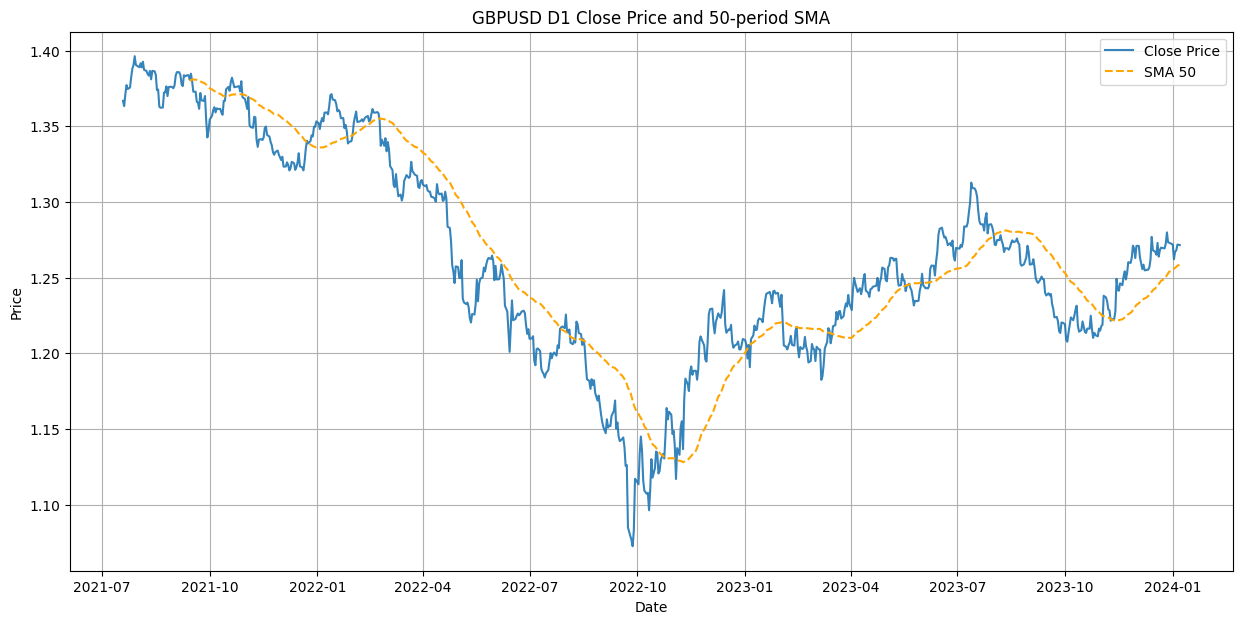

--- SMA Calculation and Plotting Cell Complete ---


In [23]:
# Cell 3: Calculate and Inspect 50 SMA on D1 Data
print("--- Calculating SMA ---") 

# Checks if df_d1 exists and was loaded correctly from Cell 2
if 'df_d1' in locals() and df_d1 is not None:
    print("\n--- Verifying df_d1 (after SMA) for 2023-12-25 ---")
    date_to_check = pd.Timestamp('2023-12-25', tz='UTC')
    print(f"Is '{date_to_check}' in df_d1.index (after SMA)? {date_to_check in df_d1.index}")
    if date_to_check in df_d1.index:
        print(df_d1.loc[[date_to_check]])
    # Calculate SMA and store the result in a temporary variable first
    temp_df_with_sma = calculate_sma(df_d1, price_column='close', period=50) 

    if temp_df_with_sma is not None:
        # ***** KEY CHANGE: Update your main df_d1 DataFrame *****
        df_d1 = temp_df_with_sma 
        # Now, df_d1 itself contains the 'SMA_50' column (and all original columns)

        print("\nDataFrame df_d1 now includes SMA (last 10 rows):") 
        # We print df_d1 directly to confirm it has the SMA
        if 'SMA_50' in df_d1.columns:
             print(df_d1[['close', 'SMA_50']].tail(12)) # Show close and SMA from df_d1
        else:
             print(df_d1.tail(10)) # SMA_50 column might have a different name or wasn't added
             print("Warning: 'SMA_50' column not found in the updated df_d1. Check calculate_sma function's output column name.")

        # --- Visual Verification: Plot Close Price and SMA from the updated df_d1 --- 
        print("\nPlotting D1 Close Price and SMA_50 from updated df_d1...") 
        plt.figure(figsize=(15, 7)) 

        plt.plot(df_d1.index, df_d1['close'], label='Close Price', alpha=0.9) 
        
        if 'SMA_50' in df_d1.columns: 
            plt.plot(df_d1.index, df_d1['SMA_50'], label='SMA 50', color='orange', linestyle='--') 
        else: 
            print("Warning: 'SMA_50' column not found for plotting in the updated df_d1.") 
            
        plt.title('GBPUSD D1 Close Price and 50-period SMA') 
        plt.xlabel('Date') 
        plt.ylabel('Price') 
        plt.legend() 
        plt.grid(True) 
        plt.show() 
    else: 
        print("Failed to calculate SMA. calculate_sma function returned None.") 
else: 
    print("Error: df_d1 DataFrame not found or not loaded correctly. Please ensure Cell 2 ran successfully.") 

print("--- SMA Calculation and Plotting Cell Complete ---")


DataFrame with ATR (last 10 rows):
                              open     high      low    close  tick_volume  \
time                                                                         
2023-12-26 00:00:00+00:00  1.26932  1.27299  1.26742  1.27245        39834   
2023-12-27 00:00:00+00:00  1.27252  1.28022  1.26983  1.27993        53256   
2023-12-28 00:00:00+00:00  1.27997  1.28272  1.27119  1.27336        53839   
2023-12-29 00:00:00+00:00  1.27337  1.27722  1.26999  1.27308        59195   
2024-01-01 00:00:00+00:00  1.27402  1.27444  1.26765  1.27189         1696   
2024-01-02 00:00:00+00:00  1.27194  1.27523  1.26102  1.26220        64216   
2024-01-03 00:00:00+00:00  1.26224  1.26763  1.26151  1.26724        75472   
2024-01-04 00:00:00+00:00  1.26727  1.27292  1.26565  1.26803        65939   
2024-01-05 00:00:00+00:00  1.26805  1.27705  1.26103  1.27189        83754   
2024-01-07 00:00:00+00:00  1.27055  1.27181  1.27013  1.27152         1316   

                           

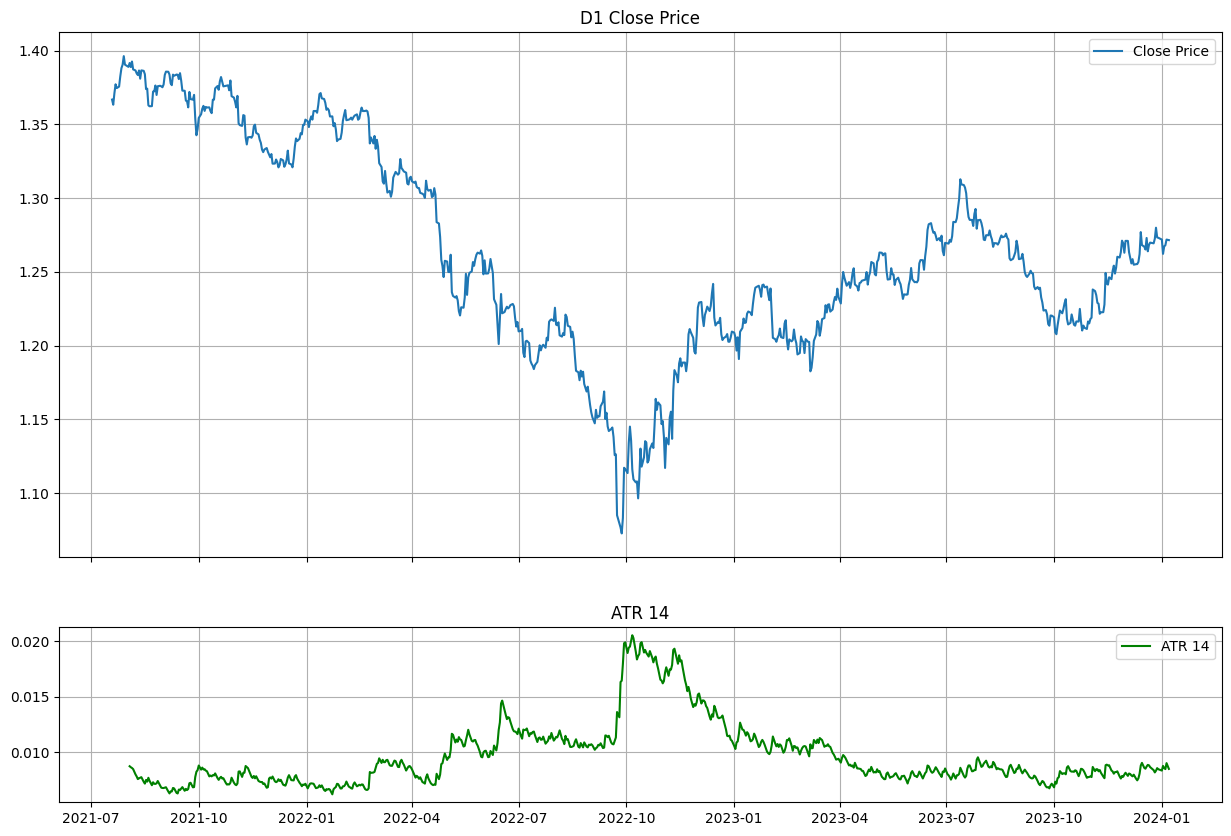

In [24]:
# Cell 4: Calculation and Inspection of ATR(14) on D1 Data
if 'df_d1' in locals() and df_d1 is not None:
    df_d1_with_atr = calculate_atr(df_d1, period=14) # Using HLC column names

    if df_d1_with_atr is not None:
        print("\nDataFrame with ATR (last 10 rows):")
        print(df_d1_with_atr.tail(10))

        # Optional: Plot ATR if desired (often in a subplot below price)
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3, 1]})
        ax[0].plot(df_d1_with_atr.index, df_d1_with_atr['close'], label='Close Price')
        ax[0].set_title('D1 Close Price')
        ax[0].legend()
        ax[0].grid(True)
        if 'ATR_14' in df_d1_with_atr.columns:
             ax[1].plot(df_d1_with_atr.index, df_d1_with_atr['ATR_14'], label='ATR 14', color='green')
             ax[1].set_title('ATR 14')
             ax[1].legend()
             ax[1].grid(True)
        plt.show()
    else:
        print("Failed to calculate ATR.")
else:
    print("Error: df_d1 DataFrame not found.")


DataFrame with RSI (last 10 rows):
                              open     high      low    close  tick_volume  \
time                                                                         
2023-12-26 00:00:00+00:00  1.26932  1.27299  1.26742  1.27245        39834   
2023-12-27 00:00:00+00:00  1.27252  1.28022  1.26983  1.27993        53256   
2023-12-28 00:00:00+00:00  1.27997  1.28272  1.27119  1.27336        53839   
2023-12-29 00:00:00+00:00  1.27337  1.27722  1.26999  1.27308        59195   
2024-01-01 00:00:00+00:00  1.27402  1.27444  1.26765  1.27189         1696   
2024-01-02 00:00:00+00:00  1.27194  1.27523  1.26102  1.26220        64216   
2024-01-03 00:00:00+00:00  1.26224  1.26763  1.26151  1.26724        75472   
2024-01-04 00:00:00+00:00  1.26727  1.27292  1.26565  1.26803        65939   
2024-01-05 00:00:00+00:00  1.26805  1.27705  1.26103  1.27189        83754   
2024-01-07 00:00:00+00:00  1.27055  1.27181  1.27013  1.27152         1316   

                           

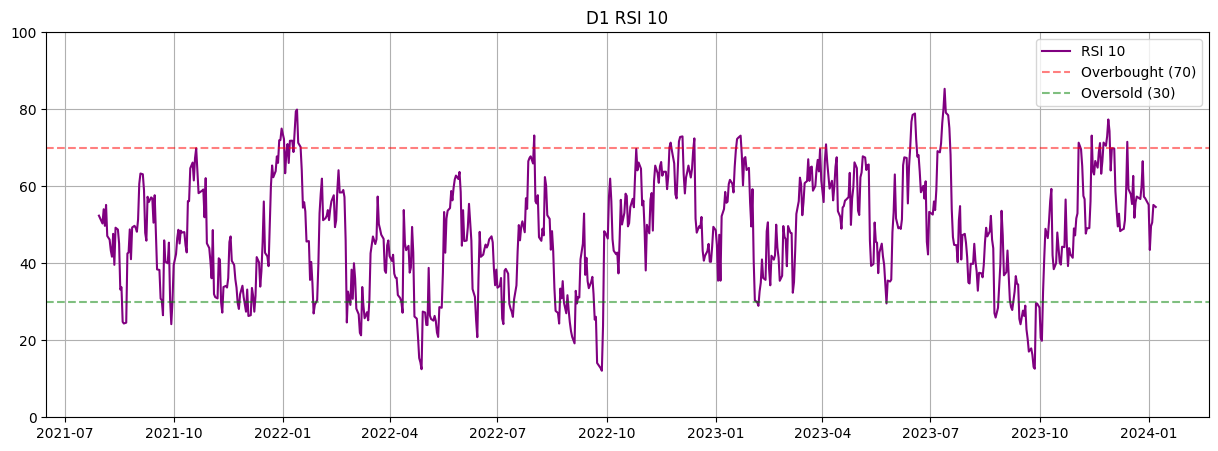

In [25]:
# Cell 5: Calculation and Inspection of RSI(10) on D1 Data
if 'df_d1_with_atr' in locals() and df_d1_with_atr is not None: # Or use df_d1 if you prefer a clean start
    df_d1_with_rsi = calculate_rsi(df_d1_with_atr, price_column='close', period=10)

    if df_d1_with_rsi is not None:
        print("\nDataFrame with RSI (last 10 rows):")
        print(df_d1_with_rsi.tail(10))

        # Optional: Plot RSI
        
        if 'RSI_10' in df_d1_with_rsi.columns:
            plt.figure(figsize=(15, 5))
            plt.plot(df_d1_with_rsi.index, df_d1_with_rsi['RSI_10'], label='RSI 10', color='purple')
            plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
            plt.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
            plt.ylim(0, 100)
            plt.title('D1 RSI 10')
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("Failed to calculate RSI.")
else:
    print("Error: df_d1_with_atr (or df_d1) DataFrame not found.")

--- Testing Basic Swing Points ---
Using df_d1 for swing point identification.

DataFrame with Potential Swing Points (last 20 rows):
                              open     high      low    close  \
time                                                            
2023-12-13 00:00:00+00:00  1.25682  1.26345  1.24996  1.26205   
2023-12-14 00:00:00+00:00  1.26208  1.27940  1.26117  1.27695   
2023-12-15 00:00:00+00:00  1.27697  1.27901  1.26676  1.26817   
2023-12-17 00:00:00+00:00  1.26667  1.26752  1.26539  1.26706   
2023-12-18 00:00:00+00:00  1.26713  1.27034  1.26282  1.26515   
2023-12-19 00:00:00+00:00  1.26524  1.27618  1.26486  1.27297   
2023-12-20 00:00:00+00:00  1.27299  1.27299  1.26225  1.26395   
2023-12-21 00:00:00+00:00  1.26396  1.26956  1.26119  1.26824   
2023-12-22 00:00:00+00:00  1.26825  1.27439  1.26784  1.26982   
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934   
2023-12-26 00:00:00+00:00  1.26932  1.27299  1.26742  1.27245   
2023-12-27 00:00:00+0

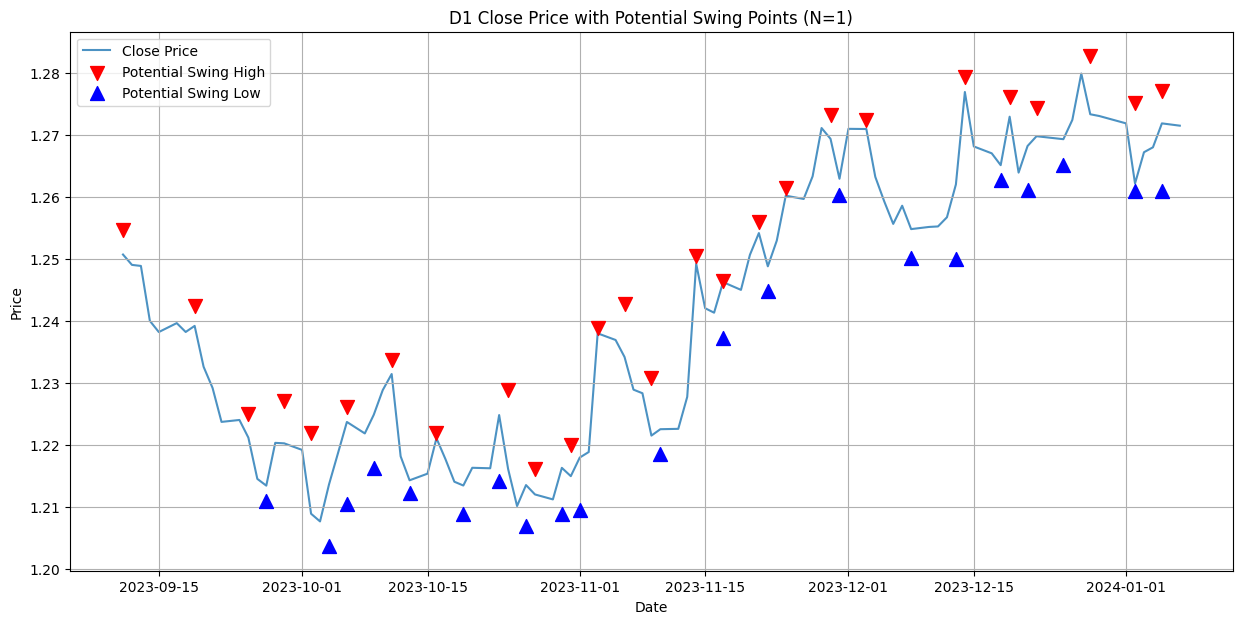


--- Verifying df_d1_swings_basic for 2023-12-25 ---
Columns in df_d1_swings_basic: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl']
Is '2023-12-25 00:00:00+00:00' in df_d1_swings_basic.index? True
Row for 2023-12-25 in df_d1_swings_basic:
                              open     high      low    close    SMA_50  \
time                                                                      
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934  1.249094   

                           is_potential_sh  is_potential_sl  
time                                                         
2023-12-25 00:00:00+00:00            False             True  
--- Basic Swing Point Test Complete ---


In [26]:
# Cell 6: Test Basic Swing Point Identification
print("--- Testing Basic Swing Points ---")
if 'df_d1_with_rsi' in locals() and df_d1_with_rsi is not None: # Or whatever your latest D1 DataFrame is called
    # Let's assume df_d1_indicators contains your D1 data with OHLC columns
    # and you've calculated SMA, ATR, RSI in previous cells and stored it
    # in a DataFrame like df_d1_indicators or df_d1_with_rsi
    # For this test, we just need the OHLC columns. Let's use df_d1 as the base.

    if 'df_d1' in locals() and df_d1 is not None:
        print("Using df_d1 for swing point identification.")
        df_d1_swings_basic = find_basic_swing_points(df_d1, N=1) 

        if df_d1_swings_basic is not None:
            print("\nDataFrame with Potential Swing Points (last 20 rows):")
            print(df_d1_swings_basic[['open', 'high', 'low', 'close', 'is_potential_sh', 'is_potential_sl']].tail(20))

            # --- Visual Verification ---
            print("\nPlotting Potential Swing Points...")
            # Select a slice of data for clearer plotting, e.g., last 100 bars
            plot_df = df_d1_swings_basic.iloc[-100:] 

            plt.figure(figsize=(15, 7))
            plt.plot(plot_df.index, plot_df['close'], label='Close Price', alpha=0.8, zorder=1)

            potential_sh = plot_df[plot_df['is_potential_sh']]
            potential_sl = plot_df[plot_df['is_potential_sl']]

            plt.scatter(potential_sh.index, potential_sh['high'], 
                        marker='v', color='red', s=100, label='Potential Swing High', zorder=2)
            plt.scatter(potential_sl.index, potential_sl['low'], 
                        marker='^', color='blue', s=100, label='Potential Swing Low', zorder=2)

            plt.title('D1 Close Price with Potential Swing Points (N=1)')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend()
            plt.grid(True)
            plt.show()
            print("\n--- Verifying df_d1_swings_basic for 2023-12-25 ---")
            date_to_check = pd.Timestamp('2023-12-25', tz='UTC') 

            if 'df_d1_swings_basic' in locals() and df_d1_swings_basic is not None:
                print(f"Columns in df_d1_swings_basic: {df_d1_swings_basic.columns.tolist()}") 
                print(f"Is '{date_to_check}' in df_d1_swings_basic.index? {date_to_check in df_d1_swings_basic.index}")
                if date_to_check in df_d1_swings_basic.index:
                   print(f"Row for {date_to_check.date()} in df_d1_swings_basic:")
                   cols_to_show_swings = ['open', 'high', 'low', 'close', 'SMA_50', 'is_potential_sh', 'is_potential_sl']
                   actual_cols_to_show_swings = [col for col in cols_to_show_swings if col in df_d1_swings_basic.columns]
                   print(df_d1_swings_basic.loc[[date_to_check]][actual_cols_to_show_swings])
                else:
                   print(f"Date {date_to_check.date()} NOT FOUND in df_d1_swings_basic.index.")
            else:
                print("df_d1_swings_basic was not created or is None.")
        else:
            print("Failed to identify basic swing points.")
    else:
        print("Error: df_d1 DataFrame not found or not loaded correctly for basic swing test.")
else:
    print("Error: Ensure your D1 DataFrame (e.g., df_d1_with_rsi or df_d1) is loaded and available.")
print("--- Basic Swing Point Test Complete ---")

--- Testing Major Swing Points (3-Candle Pullback) ---

DataFrame with Major Swing Points (last 20 where a major swing occurred):
                              open     high      low    close  \
time                                                            
2023-11-01 00:00:00+00:00  1.21501  1.21800  1.20953  1.21800   
2023-11-03 00:00:00+00:00  1.21891  1.23889  1.21839  1.23803   
2023-11-06 00:00:00+00:00  1.23713  1.24274  1.23201  1.23422   
2023-11-09 00:00:00+00:00  1.22848  1.23079  1.22095  1.22154   
2023-11-10 00:00:00+00:00  1.22157  1.22369  1.21864  1.22257   
2023-11-14 00:00:00+00:00  1.22787  1.25053  1.22649  1.24926   
2023-11-17 00:00:00+00:00  1.24139  1.24644  1.23735  1.24629   
2023-11-22 00:00:00+00:00  1.25425  1.25492  1.24481  1.24884   
2023-11-29 00:00:00+00:00  1.27119  1.27329  1.26643  1.26940   
2023-11-30 00:00:00+00:00  1.26941  1.27100  1.26030  1.26296   
2023-12-03 00:00:00+00:00  1.26918  1.27238  1.26812  1.27098   
2023-12-08 00:00:00+00:00

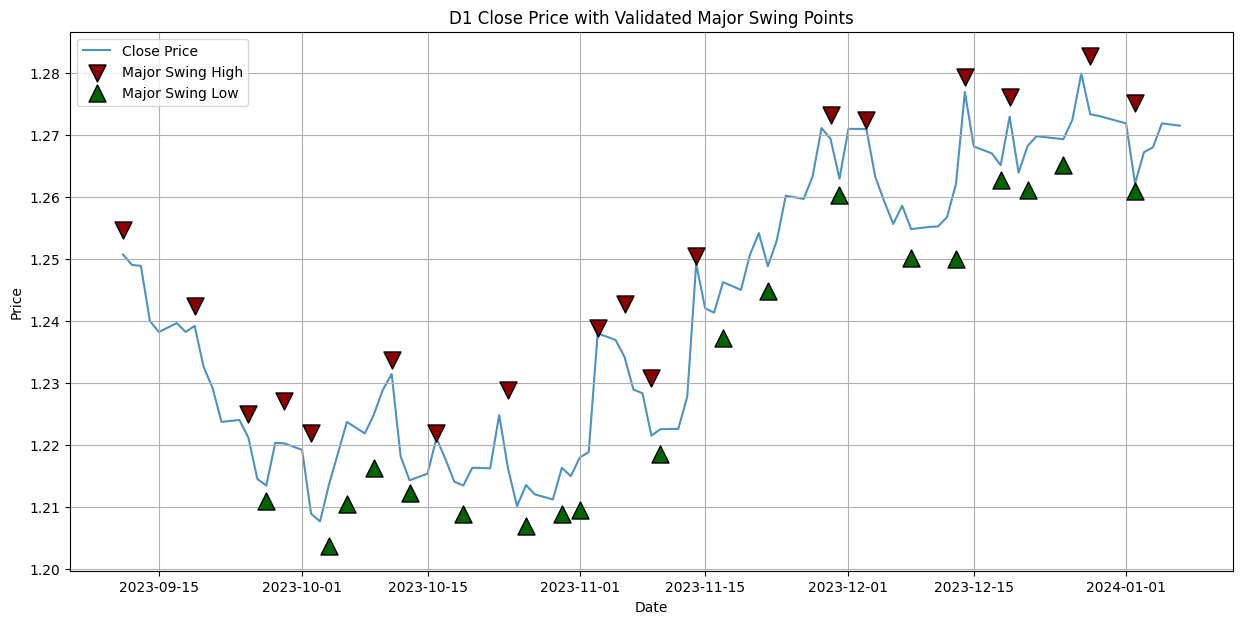


--- Verifying df_d1_major_swings for 2023-12-25 ---
Columns in df_d1_major_swings: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl']
Is '2023-12-25 00:00:00+00:00' in df_d1_major_swings.index? True
Row for 2023-12-25 in df_d1_major_swings:
                              open     high      low    close    SMA_50  \
time                                                                      
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934  1.249094   

                           is_potential_sh  is_potential_sl  is_major_sh  \
time                                                                       
2023-12-25 00:00:00+00:00            False             True        False   

                           is_major_sl  
time                                    
2023-12-25 00:00:00+00:00         True  
--- Major Swing Point Test Complete ---


In [27]:
# Cell 7: Test Major Swing Point Validation (3-Candle Pullback)
print("--- Testing Major Swing Points (3-Candle Pullback) ---")
# We use df_d1_swings_basic from the previous cell (Cell 6)
if 'df_d1_swings_basic' in locals() and df_d1_swings_basic is not None:
    df_d1_major_swings = validate_swings_with_3_candle_pullback(df_d1_swings_basic)

    if df_d1_major_swings is not None:
        print("\nDataFrame with Major Swing Points (last 20 where a major swing occurred):")
        # Filter to show rows where major swings are identified
        print(df_d1_major_swings[
            (df_d1_major_swings['is_major_sh']) | (df_d1_major_swings['is_major_sl'])
        ][['open', 'high', 'low', 'close', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl']].tail(20))

        # --- Visual Verification ---
        print("\nPlotting Major Swing Points...")
        plot_df_major = df_d1_major_swings.iloc[-100:] # Plot last 100 bars for clarity

        plt.figure(figsize=(15, 7))
        plt.plot(plot_df_major.index, plot_df_major['close'], label='Close Price', alpha=0.8, zorder=1)

        major_sh = plot_df_major[plot_df_major['is_major_sh']]
        major_sl = plot_df_major[plot_df_major['is_major_sl']]

        plt.scatter(major_sh.index, major_sh['high'], 
                    marker='v', color='darkred', s=150, label='Major Swing High', zorder=3, edgecolors='black')
        plt.scatter(major_sl.index, major_sl['low'], 
                    marker='^', color='darkgreen', s=150, label='Major Swing Low', zorder=3, edgecolors='black')

        # Optionally, also plot the potential swings for comparison
        # potential_sh_plot = plot_df_major[plot_df_major['is_potential_sh']]
        # potential_sl_plot = plot_df_major[plot_df_major['is_potential_sl']]
        # plt.scatter(potential_sh_plot.index, potential_sh_plot['high'], 
        #             marker='v', color='lightcoral', s=50, label='Potential SH', zorder=2, alpha=0.7)
        # plt.scatter(potential_sl_plot.index, potential_sl_plot['low'], 
        #             marker='^', color='lightblue', s=50, label='Potential SL', zorder=2, alpha=0.7)

        plt.title('D1 Close Price with Validated Major Swing Points')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()
        print("\n--- Verifying df_d1_major_swings for 2023-12-25 ---")
        date_to_check = pd.Timestamp('2023-12-25', tz='UTC')

        if 'df_d1_major_swings' in locals() and df_d1_major_swings is not None:
            print(f"Columns in df_d1_major_swings: {df_d1_major_swings.columns.tolist()}")
            print(f"Is '{date_to_check}' in df_d1_major_swings.index? {date_to_check in df_d1_major_swings.index}")
            if date_to_check in df_d1_major_swings.index:
                print(f"Row for {date_to_check.date()} in df_d1_major_swings:")
        # Print relevant columns
                cols_to_show_major = ['open', 'high', 'low', 'close', 'SMA_50', 
                              'is_potential_sh', 'is_potential_sl', 
                              'is_major_sh', 'is_major_sl']
                actual_cols_to_show_major = [col for col in cols_to_show_major if col in df_d1_major_swings.columns]
                print(df_d1_major_swings.loc[[date_to_check]][actual_cols_to_show_major])
            else:
                print(f"Date {date_to_check.date()} NOT FOUND in df_d1_major_swings.index.")
        else:
            print("df_d1_major_swings was not created or is None.")
    else:
        print("Failed to validate swing points.")
else:
    print("Error: df_d1_swings_basic DataFrame not found. Ensure Cell 6 ran successfully.")
print("--- Major Swing Point Test Complete ---")

--- Determining D1 Market Structure ---
DEBUG: Input df_d1_major_swings columns: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl']

--- Verifying INPUT df_d1_major_swings for 2023-12-25 (before calling determine_d1_market_structure) ---
Columns in df_d1_major_swings: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl']
Is '2023-12-25 00:00:00+00:00' in df_d1_major_swings.index? True
                              open     high      low    close  tick_volume  \
time                                                                         
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934         1598   

                             SMA_50  is_potential_sh  is_potential_sl  \
time                                                                    
2023-12-25 00:00:00+00:00  1.249094            False             True   

          

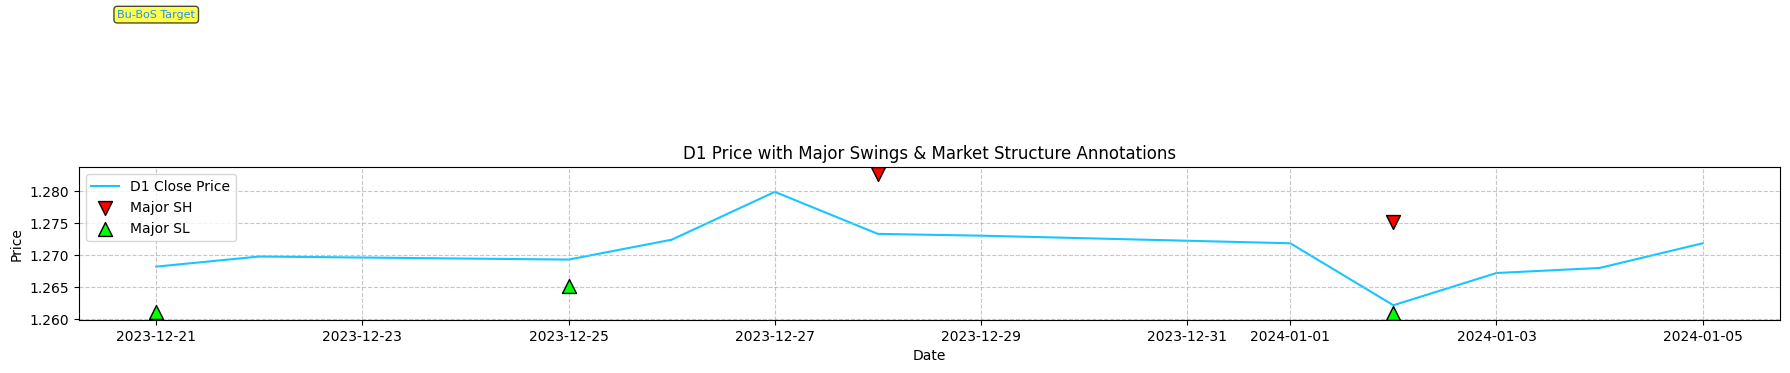


--- Verifying OUTPUT df_d1_structure for 2023-12-25 (after calling determine_d1_market_structure) ---
Columns in df_d1_structure: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl', 'd1_market_structure']
Is '2023-12-25 00:00:00+00:00' in df_d1_structure.index? True
                              open     high      low    close  tick_volume  \
time                                                                         
2023-12-25 00:00:00+00:00  1.26937  1.26998  1.26514  1.26934         1598   

                             SMA_50  is_potential_sh  is_potential_sl  \
time                                                                    
2023-12-25 00:00:00+00:00  1.249094            False             True   

                           is_major_sh  is_major_sl d1_market_structure  
time                                                                     
2023-12-25 00:00:00+00:00        False         True  Bu

In [28]:
# Cell 8: Determine D1 Market Structure, Print Outputs, and Visualize

print("--- Determining D1 Market Structure ---")

# This assumes 'df_d1_major_swings' is your DataFrame from the previous cell/step
# and it contains 'is_major_sh', 'is_major_sl', 'high', 'low', 'close' columns.
if 'df_d1_major_swings' in locals() and df_d1_major_swings is not None:
    print(f"DEBUG: Input df_d1_major_swings columns: {df_d1_major_swings.columns.tolist()}")
    print("\n--- Verifying INPUT df_d1_major_swings for 2023-12-25 (before calling determine_d1_market_structure) ---")
    date_to_check = pd.Timestamp('2023-12-25', tz='UTC')
    if 'df_d1_major_swings' in locals() and df_d1_major_swings is not None:
        print(f"Columns in df_d1_major_swings: {df_d1_major_swings.columns.tolist()}")
        print(f"Is '{date_to_check}' in df_d1_major_swings.index? {date_to_check in df_d1_major_swings.index}")
        if date_to_check in df_d1_major_swings.index:
            print(df_d1_major_swings.loc[[date_to_check]])
        else:
            print("df_d1_major_swings is not defined or is None before calling determine_d1_market_structure.")
    # Call the function to determine market structure
    # This will add the 'd1_market_structure' column
    df_d1_structure = determine_d1_market_structure(df_d1_major_swings)

    # --- Crucial Debugging Checks ---
    if df_d1_structure is not None:
        print("\n--- df_d1_structure DataFrame after function call (DEBUG) ---")
        print(f"All columns in df_d1_structure: {df_d1_structure.columns.tolist()}")
        print(f"Is 'd1_market_structure' column present? {'d1_market_structure' in df_d1_structure.columns}")
        if 'd1_market_structure' in df_d1_structure.columns and not df_d1_structure.empty:
            print(f"Sample unique value(s) from 'd1_market_structure': {df_d1_structure['d1_market_structure'].unique()[:5]}") # Show up to 5 unique values
        elif df_d1_structure.empty:
            print("'df_d1_structure' DataFrame is empty.")
        else:
            print("'d1_market_structure' column is NOT present.")
        # --- End Crucial Debugging Checks ---

        # --- Prepare plot_df_viz (the slice for plotting) ---
        print("\n--- Preparing Data Slice for Plotting ---")
        # For visual inspection, let's plot a portion of the data.
        # Ensure your DataFrame's index is a DatetimeIndex for date slicing with .loc
        if isinstance(df_d1_structure.index, pd.DatetimeIndex):
            try:
                # --- YOU CAN CHANGE THIS DATE SLICE ---
                start_date_plot = '2023-12-21' # Or any start date within your data
                end_date_plot = '2024-01-06'   # Or any end date within your data
                
                plot_df_viz = df_d1_structure.loc[start_date_plot:end_date_plot]
                
                if plot_df_viz.empty:
                    print(f"Warning: No data found for slice {start_date_plot}:{end_date_plot}. Plotting last 250 bars instead.")
                    plot_df_viz = df_d1_structure.iloc[-250:]
                else:
                    print(f"Successfully sliced data for plotting: {plot_df_viz.shape[0]} rows from {start_date_plot} to {end_date_plot}")

            except KeyError:
                print(f"Warning: Date range for slicing ({start_date_plot}:{end_date_plot}) not found or index not sorted. Plotting last 250 bars instead.")
                plot_df_viz = df_d1_structure.iloc[-250:]
            except Exception as e_slice:
                print(f"An unexpected error during date slicing: {e_slice}. Plotting last 250 bars.")
                plot_df_viz = df_d1_structure.iloc[-250:]
        else:
            print("Warning: DataFrame index is not DatetimeIndex. Plotting last 250 bars using iloc.")
            plot_df_viz = df_d1_structure.iloc[-250:]
        
        # --- Print Head and Tail of the Sliced Data (plot_df_viz) ---
        if not plot_df_viz.empty:
            print(f"\n--- Data for Sliced Period Being Plotted ({plot_df_viz.index.min().date()} to {plot_df_viz.index.max().date()}) ---")
            display_cols_slice = ['close', 'high', 'low', 'is_major_sh', 'is_major_sl', 'd1_market_structure']
            actual_display_cols_slice = [col for col in display_cols_slice if col in plot_df_viz.columns]
            
            if actual_display_cols_slice:
                 print(f"Columns selected for sliced display: {actual_display_cols_slice}")
                 print("Head of the sliced data (plot_df_viz):")
                 print(plot_df_viz[actual_display_cols_slice].head(10)) 
                 print("\nTail of the sliced data (plot_df_viz):")
                 print(plot_df_viz[actual_display_cols_slice].tail(10))
            else:
                 print("Warning: Could not find expected columns in plot_df_viz for printing head/tail.")
        else:
            print("plot_df_viz is empty after slicing attempt. Cannot print head/tail of slice.")


        # --- Print Value Counts for the Full DataFrame ---
        print("\nUnique D1 market structure states found and their counts (from full DataFrame):")
        if 'd1_market_structure' in df_d1_structure.columns:
            print(df_d1_structure['d1_market_structure'].value_counts(dropna=False)) 
        else:
            print("'d1_market_structure' column not found to count values in full DataFrame.")

        # --- Visual Verification using plot_df_viz ---
        if not plot_df_viz.empty:
            print("\n--- Visualizing D1 Price, Major Swings, and Structure State Changes (for sliced period) ---")
            plt.figure(figsize=(18, 10)) 
            
            plt.plot(plot_df_viz.index, plot_df_viz['close'], label='D1 Close Price', color='deepskyblue', alpha=0.9, zorder=1)

            major_sh_to_plot = plot_df_viz[plot_df_viz['is_major_sh']]
            if not major_sh_to_plot.empty:
                plt.scatter(major_sh_to_plot.index, major_sh_to_plot['high'], 
                            marker='v', color='red', s=100, label='Major SH', zorder=3, edgecolors='black')

            major_sl_to_plot = plot_df_viz[plot_df_viz['is_major_sl']]
            if not major_sl_to_plot.empty:
                plt.scatter(major_sl_to_plot.index, major_sl_to_plot['low'], 
                            marker='^', color='lime', s=100, label='Major SL', zorder=3, edgecolors='black')
            
            previous_structure = None
            for idx, row in plot_df_viz.iterrows():
                current_structure = row['d1_market_structure']
                if pd.notna(current_structure) and current_structure != previous_structure:
                    annotate_text = None
                    text_color = 'black'
                    y_position_offset_factor = 0.015 

                    if "Bearish BoS Target" == current_structure:
                        annotate_text = "B-BoS Target"
                        y_position = row['low'] * (1 - y_position_offset_factor*2) 
                        text_color = 'mediumvioletred'
                    elif "Bullish BoS Target" == current_structure:
                        annotate_text = "Bu-BoS Target"
                        y_position = row['high'] * (1 + y_position_offset_factor*2) 
                        text_color = 'dodgerblue'
                    elif "Confirmed post-BoS" in str(current_structure) and ("Bearish" in str(current_structure) or "Downtrend" == current_structure) : 
                         annotate_text = "DT Confirmed (BoS)"
                         y_position = row['high'] * (1 + y_position_offset_factor)
                         text_color = 'darkred'
                    elif "Confirmed post-BoS" in str(current_structure) and ("Bullish" in str(current_structure) or "Uptrend" == current_structure) :
                         annotate_text = "UT Confirmed (BoS)"
                         y_position = row['low'] * (1 - y_position_offset_factor)
                         text_color = 'darkgreen'
                    elif current_structure == "Uptrend" and (previous_structure != "Uptrend" and (previous_structure is None or "BoS" not in str(previous_structure))):
                         annotate_text = "Uptrend"
                         y_position = row['low'] * (1 - y_position_offset_factor)
                         text_color = 'green'
                    elif current_structure == "Downtrend" and (previous_structure != "Downtrend" and (previous_structure is None or "BoS" not in str(previous_structure))):
                         annotate_text = "Downtrend"
                         y_position = row['high'] * (1 + y_position_offset_factor)
                         text_color = 'red'

                    if annotate_text:
                        plt.text(idx, y_position, annotate_text, rotation=0, fontsize=8, 
                                 color=text_color, ha='center', va='center',
                                 bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="black", alpha=0.7))
                previous_structure = current_structure
                
            plt.title('D1 Price with Major Swings & Market Structure Annotations')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.legend(loc='upper left')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout() 
            plt.show()
            print("\n--- Verifying OUTPUT df_d1_structure for 2023-12-25 (after calling determine_d1_market_structure) ---")
            date_to_check = pd.Timestamp('2023-12-25', tz='UTC')
            if 'df_d1_structure' in locals() and df_d1_structure is not None:
                print(f"Columns in df_d1_structure: {df_d1_structure.columns.tolist()}")
                print(f"Is '{date_to_check}' in df_d1_structure.index? {date_to_check in df_d1_structure.index}")
                if date_to_check in df_d1_structure.index:
                    print(df_d1_structure.loc[[date_to_check]])
                else:
                    print(f"Date {date_to_check.date()} NOW MISSING from df_d1_structure.index!")
            else:
                print("df_d1_structure is None (function might have returned None).")
        else:
            print("plot_df_viz is empty. Cannot plot. Check your date slicing logic or original DataFrame length.")

    else:
        print("Failed to determine market structure: your `determine_d1_market_structure` function returned None.")
        print("Please check for errors or early return statements within that function in your trss_D1.py file,")
        print("or ensure the input DataFrame 'df_d1_major_swings' was valid.")
else:
    print("Error: `df_d1_major_swings` DataFrame not found in notebook memory.")
    print("Please ensure your previous cells (that create `df_d1_major_swings`) ran successfully.")

print("--- D1 Market Structure Test Complete ---")

In [29]:
# In your notebook
date_to_check_d1 = pd.Timestamp('2023-12-25', tz='UTC').normalize() # Get just the date part
if 'df_d1_structure' in locals() and df_d1_structure is not None:
    if date_to_check_d1 in df_d1_structure.index:
        print(f"\n--- D1 Context for {date_to_check_d1.date()} from df_d1_structure (Notebook) ---")
        print(df_d1_structure.loc[date_to_check_d1][['close', 'SMA_50', 'is_major_sl', 'd1_market_structure']])
    else:
        print(f"Error: Date {date_to_check_d1.date()} not found in df_d1_structure.index")
else:
    print("Error: df_d1_structure not found in notebook.")


--- D1 Context for 2023-12-25 from df_d1_structure (Notebook) ---
close                             1.26934
SMA_50                           1.249094
is_major_sl                          True
d1_market_structure    Bullish BoS Target
Name: 2023-12-25 00:00:00+00:00, dtype: object


--- Loading H1 Data ---
Attempting to load H1 data from: c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\data\splits\GBPUSDm_H1_train.csv
Successfully loaded and processed data from: c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\data\splits\GBPUSDm_H1_train.csv

H1 Data loaded successfully into df_h1!
                              open     high      low    close  tick_volume
time                                                                      
2021-07-19 00:00:00+00:00  1.37630  1.37633  1.37479  1.37499         1711
2021-07-19 01:00:00+00:00  1.37499  1.37609  1.37497  1.37534         2118
2021-07-19 02:00:00+00:00  1.37531  1.37569  1.37467  1.37473         1551
2021-07-19 03:00:00+00:00  1.37473  1.37557  1.37473  1.37555         1011
2021-07-19 04:00:00+00:00  1.37555  1.37607  1.37526  1.37550          872
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1

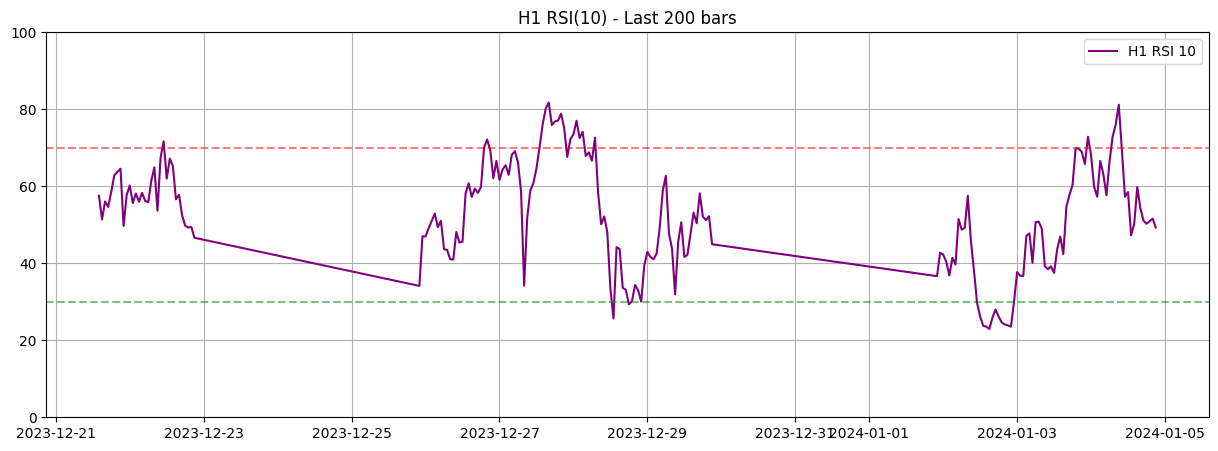

--- H1 Data Loading and Indicator Cell Complete ---


In [30]:
# Cell 9: Load H1 Data and Calculate H1 Indicators

print("--- Loading H1 Data ---")
# project_root should be defined from Cell 1
h1_file_path = os.path.join(project_root, 'data', 'splits', 'GBPUSDm_H1_train.csv') # Replace with your H1 filename
print(f"Attempting to load H1 data from: {h1_file_path}")

df_h1 = load_price_data_from_csv(
    file_path=h1_file_path,
    datetime_col_name='time',    # Or your actual H1 datetime column name
    open_col='open',
    high_col='high',
    low_col='low',
    close_col='close',
    volume_col='tick_volume',
    desired_timezone='UTC'
)

if df_h1 is not None:
    print("\nH1 Data loaded successfully into df_h1!")
    print(df_h1.head())
    df_h1.info()

    # --- Calculate H1 Indicators ---
    print("\n--- Calculating H1 Indicators (RSI(10) and ATR(14)) ---")
    # Ensure calculate_rsi and calculate_atr are imported in Cell 1
    from src.core_logic.indicators import calculate_sma, calculate_atr, calculate_rsi
    
    df_h1_indicators = calculate_rsi(df_h1, price_column='close', period=10)
    if df_h1_indicators is not None:
        df_h1_indicators = calculate_atr(df_h1_indicators, period=14) # Add ATR to the same DataFrame
    
    if df_h1_indicators is not None and 'RSI_10' in df_h1_indicators.columns and 'ATR_14' in df_h1_indicators.columns:
        print("\nSuccessfully calculated H1 RSI(10) and ATR(14).")
        print(df_h1_indicators[['close', 'RSI_10', 'ATR_14']].tail())
        
        # Optional: Plot H1 RSI
        plt.figure(figsize=(15, 5))
        plt.plot(df_h1_indicators.index[-200:], df_h1_indicators['RSI_10'].iloc[-200:], label='H1 RSI 10', color='purple')
        plt.axhline(70, color='red', linestyle='--', alpha=0.5); plt.axhline(30, color='green', linestyle='--', alpha=0.5)
        plt.ylim(0,100); plt.title('H1 RSI(10) - Last 200 bars'); plt.legend(); plt.grid(True); plt.show()

    else:
        print("Failed to calculate all H1 indicators or add them to the DataFrame.")
else:
    print("\nH1 Data loading failed.")

print("--- H1 Data Loading and Indicator Cell Complete ---")

--- Identifying H1 Swing Points for W-Pattern input ---
Potential H1 Swing Lows found: 1481
Potential H1 Swing Highs found: 1432

--- Identifying W-Patterns with Divergence ---
W-Pattern Buy Signals identified: 254

Total W-Pattern Buy Signals generated: 254
Last 5 identified W-Pattern Buy Signals (on confirmation candle):
                             close      low     RSI_10    ATR_14
time                                                            
2023-12-21 04:00:00+00:00  1.26399  1.26319  42.029185  0.001565
2023-12-21 18:00:00+00:00  1.26733  1.26586  58.564764  0.002104
2023-12-29 15:00:00+00:00  1.27470  1.27229  53.157375  0.002256
2024-01-02 05:00:00+00:00  1.27287  1.27059  51.484297  0.002095
2024-01-03 16:00:00+00:00  1.26403  1.26266  54.725779  0.001905

--- Plotting around the last identified W-Pattern signal (if any) ---


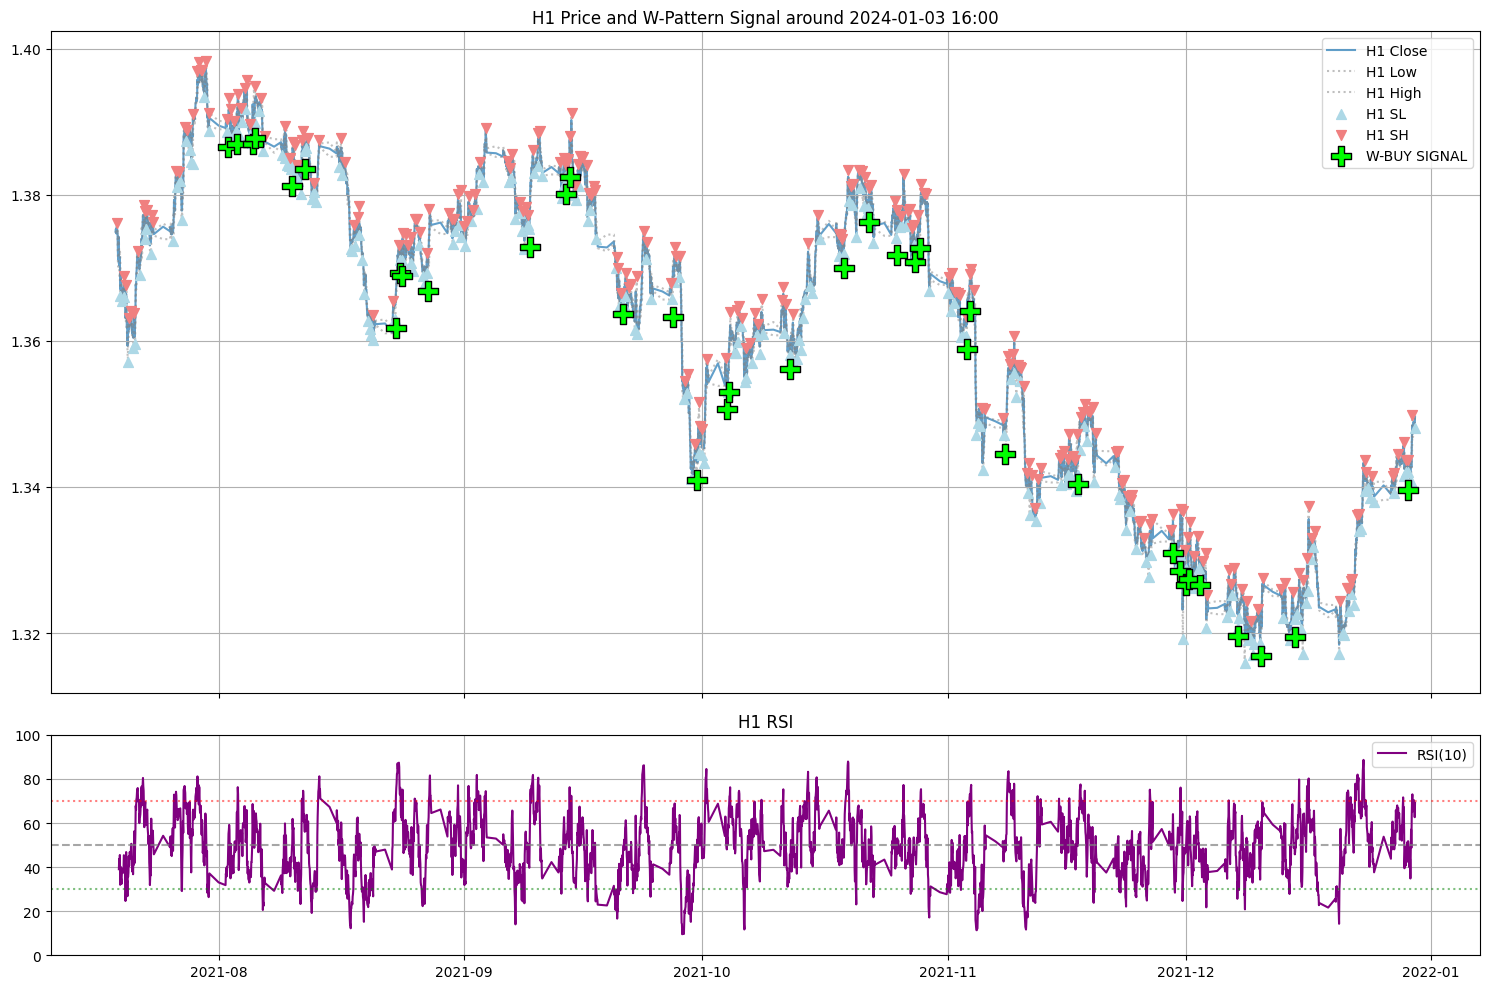

--- H1 W-Pattern Test Complete ---


In [31]:
# Cell 10: Test H1 Swing Points and W-Pattern Identification

if 'df_h1_indicators' in locals() and df_h1_indicators is not None:
    print("--- Identifying H1 Swing Points for W-Pattern input ---")
    # Adjust N for H1 swing points as needed. N=9 is a starting guess.
    df_h1_with_swings = find_h1_swing_points(df_h1_indicators, N=3, high_col='high', low_col='low')
    
    if df_h1_with_swings is not None and \
       'is_h1_sl' in df_h1_with_swings.columns and \
       'is_h1_sh' in df_h1_with_swings.columns:
        
        print(f"Potential H1 Swing Lows found: {df_h1_with_swings['is_h1_sl'].sum()}")
        print(f"Potential H1 Swing Highs found: {df_h1_with_swings['is_h1_sh'].sum()}")

        print("\n--- Identifying W-Patterns with Divergence ---")
        # Pass the DataFrame that now includes H1 swing booleans, RSI, and ATR
        df_h1_with_w_patterns = identify_w_pattern_with_divergence(
            h1_df_with_swings_rsi_atr=df_h1_with_swings, 
            h1_sl_col='is_h1_sl',    
            h1_sh_col='is_h1_sh',   
            low_col='low', 
            high_col='high', 
            close_col='close',
            open_col='open',         
            rsi_col='RSI_10', 
            atr_col='ATR_14',
            price_tolerance_atr_multiplier=1.0, 
            min_peak_prominence_atr_multiplier=0.1,
            max_bars_between_bottoms = 80,
            confirmation_lookback = 5 
        )

        if df_h1_with_w_patterns is not None and 'w_pattern_buy_signal' in df_h1_with_w_patterns.columns:
            w_signals_df = df_h1_with_w_patterns[df_h1_with_w_patterns['w_pattern_buy_signal']]
            print(f"\nTotal W-Pattern Buy Signals generated: {len(w_signals_df)}")
            
            if not w_signals_df.empty:
                print("Last 5 identified W-Pattern Buy Signals (on confirmation candle):")
                print(w_signals_df[['close', 'low', 'RSI_10', 'ATR_14']].tail()) # Added 'low' for context

                # --- Plotting to verify (select a period around a signal) ---
                print("\n--- Plotting around the last identified W-Pattern signal (if any) ---")
                last_signal_time = w_signals_df.index[-1] # Time of the confirmation candle
                
                # Define a window around the signal for plotting
                # Go back enough to see B1, P1, B2. max_bars_between_bottoms gives an idea.
                # lookback_for_plot = pd.Timedelta(hours=(200 + 5) * 1.5) # max_bars + buffer, roughly
                # plot_start_time = last_signal_time - lookback_for_plot 
                # plot_end_time = last_signal_time + pd.Timedelta(hours=12)   # Look forward a bit
                
                plot_slice = df_h1_with_w_patterns.loc['2021-07-19':'2021-12-29']

                if not plot_slice.empty:
                    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3,1]})
                    
                    ax[0].plot(plot_slice.index, plot_slice['close'], label='H1 Close', zorder=1, alpha=0.7)
                    ax[0].plot(plot_slice.index, plot_slice['low'], label='H1 Low', color='grey', linestyle=':', alpha=0.5, zorder=1)
                    ax[0].plot(plot_slice.index, plot_slice['high'], label='H1 High', color='grey', linestyle=':', alpha=0.5, zorder=1)
                    
                    h1_sl_in_slice = plot_slice[plot_slice['is_h1_sl']]
                    h1_sh_in_slice = plot_slice[plot_slice['is_h1_sh']]
                    ax[0].scatter(h1_sl_in_slice.index, h1_sl_in_slice['low'], marker='^', color='lightblue', s=50, label='H1 SL', zorder=2)
                    ax[0].scatter(h1_sh_in_slice.index, h1_sh_in_slice['high'], marker='v', color='lightcoral', s=50, label='H1 SH', zorder=2)

                    signal_markers_in_slice = plot_slice[plot_slice['w_pattern_buy_signal']]
                    ax[0].scatter(signal_markers_in_slice.index, signal_markers_in_slice['low'] * 0.998, 
                                  marker='P', color='lime', s=200, label='W-BUY SIGNAL', zorder=5, edgecolors='black')
                    
                    ax[0].set_title(f'H1 Price and W-Pattern Signal around {last_signal_time.strftime("%Y-%m-%d %H:%M")}')
                    ax[0].legend(); ax[0].grid(True)

                    ax[1].plot(plot_slice.index, plot_slice['RSI_10'], label='RSI(10)', color='purple')
                    ax[1].axhline(50, linestyle='--', color='grey', alpha=0.7)
                    ax[1].axhline(30, linestyle=':', color='green', alpha=0.5)
                    ax[1].axhline(70, linestyle=':', color='red', alpha=0.5)
                    ax[1].set_title('H1 RSI'); ax[1].legend(); ax[1].grid(True); ax[1].set_ylim(0,100)
                    
                    plt.tight_layout(); plt.show()
                else:
                    print(f"Could not create a plot slice around the last signal time: {last_signal_time}")
            else:
                print("No W-pattern signals found to plot with current parameters/data.")
        else:
            print("W-Pattern identification function returned None or 'w_pattern_buy_signal' column missing.")
    else:
        print("H1 swing point identification failed or df_h1_with_swings is None, or key columns missing.")
else:
    print("df_h1_indicators DataFrame not found. Please ensure H1 data is loaded and indicators are calculated.")

print("--- H1 W-Pattern Test Complete ---")



--- Identifying M-Patterns with Divergence ---
M-Pattern Sell Signals identified: 50

Total M-Pattern Sell Signals generated: 50
Last 5 identified M-Pattern Sell Signals (on confirmation candle):
                             close     high     RSI_10    ATR_14
time                                                            
2023-08-23 08:00:00+00:00  1.26783  1.27360  20.729838  0.001860
2023-11-01 08:00:00+00:00  1.21436  1.21601  48.053939  0.001403
2023-11-01 15:00:00+00:00  1.21259  1.21563  44.426702  0.002023
2023-11-22 22:00:00+00:00  1.24870  1.24932  40.940048  0.001655
2023-12-12 14:00:00+00:00  1.25254  1.25664  30.970990  0.002158

--- Plotting around the last identified M-Pattern signal (if any) ---


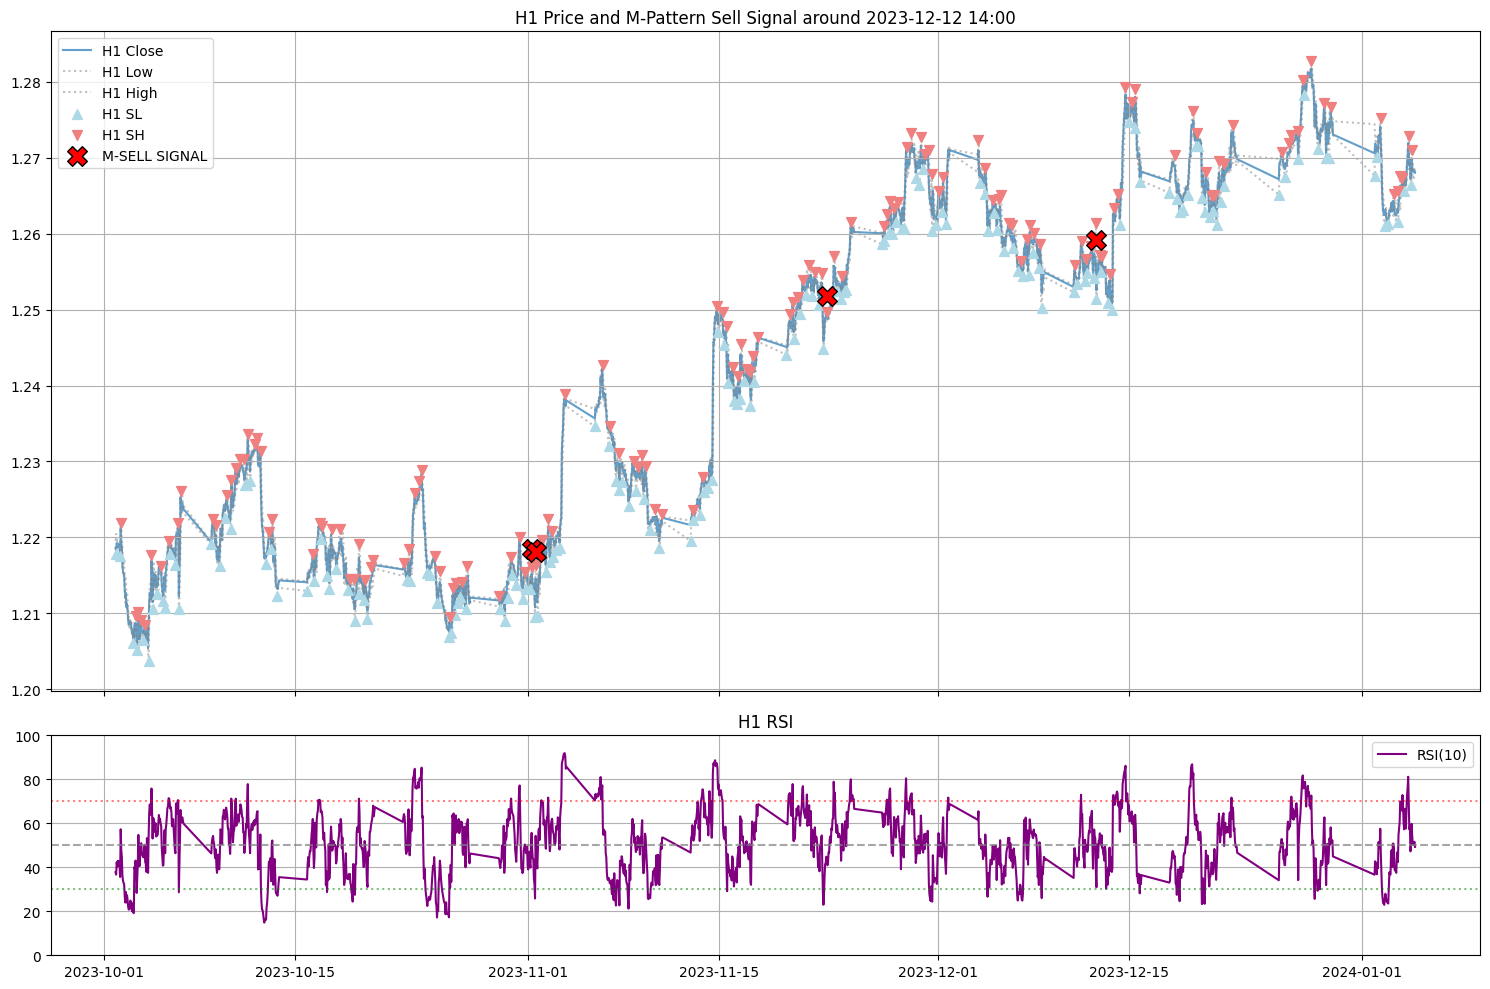

--- H1 M-Pattern Test Complete ---


In [32]:
# Cell 11: Test H1 M-Pattern Identification

# and that identify_m_pattern_with_divergence is imported in Cell 1.
# from src.core_logic.patterns_H1 import find_h1_swing_points, identify_w_pattern_with_divergence, identify_m_pattern_with_divergence


if 'df_h1_with_w_patterns' in locals() and df_h1_with_w_patterns is not None:
    print("\n--- Identifying M-Patterns with Divergence ---")
    # Pass the DataFrame that now includes H1 swing booleans, RSI, and ATR
    df_h1_final_patterns = identify_m_pattern_with_divergence( # Use the M-pattern function
        h1_df_with_swings_rsi_atr=df_h1_with_w_patterns,  # Assuming this df has results from W-pattern or just swings
        h1_sl_col='is_h1_sl',    
        h1_sh_col='is_h1_sh',    
        low_col='low', 
        high_col='high', 
        close_col='close',
        open_col='open',         
        rsi_col='RSI_10', 
        atr_col='ATR_14',
        price_tolerance_atr_multiplier=1.0, 
        min_valley_prominence_atr_multiplier=0.1,
        max_bars_between_tops=80,
        confirmation_lookback=5
    )

    if df_h1_final_patterns is not None and 'm_pattern_sell_signal' in df_h1_final_patterns.columns:
        m_signals_df = df_h1_final_patterns[df_h1_final_patterns['m_pattern_sell_signal']]
        print(f"\nTotal M-Pattern Sell Signals generated: {len(m_signals_df)}")
        
        if not m_signals_df.empty:
            print("Last 5 identified M-Pattern Sell Signals (on confirmation candle):")
            print(m_signals_df[['close', 'high', 'RSI_10', 'ATR_14']].tail())

            print("\n--- Plotting around the last identified M-Pattern signal (if any) ---")
            last_signal_time_m = m_signals_df.index[-1]
            
            # lookback_for_plot_m = pd.Timedelta(hours= (200 + 5) * 1.5 ) 
            # plot_start_time_m = last_signal_time_m - lookback_for_plot_m 
            # plot_end_time_m = last_signal_time_m + pd.Timedelta(hours=24)   
            
            plot_slice_m = df_h1_final_patterns.loc['2023-10-01':'2024-01-05']

            if not plot_slice_m.empty:
                fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,10), gridspec_kw={'height_ratios': [3,1]})
                
                ax[0].plot(plot_slice_m.index, plot_slice_m['close'], label='H1 Close', zorder=1, alpha=0.7)
                ax[0].plot(plot_slice_m.index, plot_slice_m['low'], label='H1 Low', color='grey', linestyle=':', alpha=0.5, zorder=1)
                ax[0].plot(plot_slice_m.index, plot_slice_m['high'], label='H1 High', color='grey', linestyle=':', alpha=0.5, zorder=1)
                
                h1_sl_in_slice_m = plot_slice_m[plot_slice_m['is_h1_sl']]
                h1_sh_in_slice_m = plot_slice_m[plot_slice_m['is_h1_sh']]
                ax[0].scatter(h1_sl_in_slice_m.index, h1_sl_in_slice_m['low'], marker='^', color='lightblue', s=50, label='H1 SL', zorder=2)
                ax[0].scatter(h1_sh_in_slice_m.index, h1_sh_in_slice_m['high'], marker='v', color='lightcoral', s=50, label='H1 SH', zorder=2)

                signal_markers_in_slice_m = plot_slice_m[plot_slice_m['m_pattern_sell_signal']]
                ax[0].scatter(signal_markers_in_slice_m.index, signal_markers_in_slice_m['high'] * 1.002, 
                              marker='X', color='red', s=200, label='M-SELL SIGNAL', zorder=5, edgecolors='black')
                
                ax[0].set_title(f'H1 Price and M-Pattern Sell Signal around {last_signal_time_m.strftime("%Y-%m-%d %H:%M")}')
                ax[0].legend(); ax[0].grid(True)

                ax[1].plot(plot_slice_m.index, plot_slice_m['RSI_10'], label='RSI(10)', color='purple')
                ax[1].axhline(50, linestyle='--', color='grey', alpha=0.7); ax[1].axhline(30, linestyle=':', color='green', alpha=0.5); ax[1].axhline(70, linestyle=':', color='red', alpha=0.5)
                ax[1].set_title('H1 RSI'); ax[1].legend(); ax[1].grid(True); ax[1].set_ylim(0,100)
                
                plt.tight_layout(); plt.show()
            else:
                print(f"Could not create a plot slice around the last M-pattern signal time: {last_signal_time_m}")
        else:
            print("No M-pattern signals found to plot with current parameters/data.")
    else:
        print("M-Pattern identification function returned None or 'm_pattern_sell_signal' column missing.")
else:
    print("df_h1_with_swings DataFrame not found. Please ensure H1 swings were identified in the previous cell.")

print("--- H1 M-Pattern Test Complete ---")

In [33]:
print("\n--- Checking df_h1_final_patterns for 2023-12-25 ---")
h1_date_to_check = pd.Timestamp('2023-12-25', tz='UTC').normalize()

# Create a boolean series for dates matching 2023-12-25
h1_on_xmas = df_h1_final_patterns.index.normalize() == h1_date_to_check

if h1_on_xmas.any():
    print(f"H1 data found for 2023-12-25 in df_h1_final_patterns. Count: {h1_on_xmas.sum()}")
    print(df_h1_final_patterns[h1_on_xmas].head())
    # Check the W-pattern signal specifically for the 23:00 bar
    specific_h1_bar_to_check = pd.Timestamp('2023-12-25 23:00:00+00:00', tz='UTC')
    if specific_h1_bar_to_check in df_h1_final_patterns.index:
        print(f"\nData for specific H1 bar {specific_h1_bar_to_check}:")
        print(df_h1_final_patterns.loc[[specific_h1_bar_to_check]])
    else:
        print(f"Specific H1 bar {specific_h1_bar_to_check} NOT FOUND in df_h1_final_patterns.index.")
else:
    print("No H1 data found for 2023-12-25 in df_h1_final_patterns.")


--- Checking df_h1_final_patterns for 2023-12-25 ---
H1 data found for 2023-12-25 in df_h1_final_patterns. Count: 2
                              open     high      low    close  tick_volume  \
time                                                                         
2023-12-25 22:00:00+00:00  1.26937  1.26988  1.26514  1.26719          318   
2023-12-25 23:00:00+00:00  1.26750  1.26998  1.26736  1.26934         1280   

                              RSI_10    ATR_14  is_h1_sh  is_h1_sl  \
time                                                                 
2023-12-25 22:00:00+00:00  34.125171  0.002108     False      True   
2023-12-25 23:00:00+00:00  47.024163  0.002157     False     False   

                           w_pattern_buy_signal  m_pattern_sell_signal  
time                                                                    
2023-12-25 22:00:00+00:00                 False                  False  
2023-12-25 23:00:00+00:00                 False                  False

In [34]:
# Cell for Testing Signal Engine (e.g., Cell 12)

print("--- Generating Rules-Based Signals ---")

# Ensure input DataFrames exist from previous cells
if 'df_d1_structure' in locals() and df_d1_structure is not None and \
   'df_h1_final_patterns' in locals() and df_h1_final_patterns is not None:

    # DEBUG: Print columns of input DataFrames
    print(f"DEBUG (Notebook): Columns in df_d1_structure for signal engine: {df_d1_structure.columns.tolist()}")
    print(f"DEBUG (Notebook): Columns in df_h1_final_patterns for signal engine: {df_h1_final_patterns.columns.tolist()}")
    # DEBUG: Check a few rows of H1 patterns to ensure signals are present
    print("DEBUG (Notebook): Sample of H1 W-Pattern signals:")
    print(df_h1_final_patterns[df_h1_final_patterns['w_pattern_buy_signal'] == True][['close', 'w_pattern_buy_signal']].head())
    print("DEBUG (Notebook): Sample of H1 M-Pattern signals:")
    print(df_h1_final_patterns[df_h1_final_patterns['m_pattern_sell_signal'] == True][['close', 'm_pattern_sell_signal']].head())


    # Call the function from signal_engine.py (which now has internal debug prints)
    df_h1_with_signals = generate_rules_based_signals(
        df_d1_structure, 
        df_h1_final_patterns,
        d1_close_col='close',                 # Ensure this matches df_d1_structure
        d1_sma_col='SMA_50',                  # Ensure this matches df_d1_structure
        d1_structure_col='d1_market_structure', # Ensure this matches df_d1_structure
        h1_w_pattern_col='w_pattern_buy_signal',    # Ensure this matches df_h1_final_patterns
        h1_m_pattern_col='m_pattern_sell_signal'    # Ensure this matches df_h1_final_patterns
        # Add h1_hs_buy_col and h1_hs_sell_col if you implement H&S patterns later
    )

    if df_h1_with_signals is not None and 'rules_signal' in df_h1_with_signals.columns:
        print("\n--- Signal Engine Output (from Notebook) ---")
        
        rule_signals_df = df_h1_with_signals[df_h1_with_signals['rules_signal'] != "NO_RULE_SIGNAL"]
        
        if not rule_signals_df.empty:
            print(f"Total BUY_RULE/SELL_RULE signals generated: {len(rule_signals_df)}")
            print("Showing last 50 signals (or fewer if not many):")
            
            cols_to_show = ['close', 'rules_signal'] 
            d1_context_cols_in_h1 = [col for col in df_h1_with_signals.columns if '_d1_ctx' in col]
            cols_to_show.extend(d1_context_cols_in_h1)
            if 'w_pattern_buy_signal' in df_h1_with_signals.columns: cols_to_show.append('w_pattern_buy_signal')
            if 'm_pattern_sell_signal' in df_h1_with_signals.columns: cols_to_show.append('m_pattern_sell_signal')
            
            final_cols_to_show = [col for col in cols_to_show if col in rule_signals_df.columns]
            print(rule_signals_df[final_cols_to_show].tail(50))
        else:
            print("No BUY_RULE or SELL_RULE signals were generated by the signal engine with current H1 patterns and D1 context.")
        
        print("\nValue counts for 'rules_signal' (from all H1 bars):")
        print(df_h1_with_signals['rules_signal'].value_counts(dropna=False))
    else:
        print("Signal engine did not run successfully or the 'rules_signal' column is missing.")
else:
    print("Error: df_d1_structure or df_h1_final_patterns not found or are None. Ensure previous cells ran successfully and created these DataFrames.")

print("--- Signal Engine Test Complete ---")

--- Generating Rules-Based Signals ---
DEBUG (Notebook): Columns in df_d1_structure for signal engine: ['open', 'high', 'low', 'close', 'tick_volume', 'SMA_50', 'is_potential_sh', 'is_potential_sl', 'is_major_sh', 'is_major_sl', 'd1_market_structure']
DEBUG (Notebook): Columns in df_h1_final_patterns for signal engine: ['open', 'high', 'low', 'close', 'tick_volume', 'RSI_10', 'ATR_14', 'is_h1_sh', 'is_h1_sl', 'w_pattern_buy_signal', 'm_pattern_sell_signal']
DEBUG (Notebook): Sample of H1 W-Pattern signals:
                             close  w_pattern_buy_signal
time                                                    
2021-08-02 03:00:00+00:00  1.38979                  True
2021-08-03 07:00:00+00:00  1.39129                  True
2021-08-05 07:00:00+00:00  1.39242                  True
2021-08-05 14:00:00+00:00  1.39322                  True
2021-08-10 07:00:00+00:00  1.38517                  True
DEBUG (Notebook): Sample of H1 M-Pattern signals:
                             close  m_p

In [35]:
# Cell 13: Calculate Stop Loss (SL) and Take Profit (TP) Levels

print("--- Calculating SL/TP Levels for Rule-Based Signals ---")

# This assumes 'df_h1_with_signals' is your DataFrame from Cell 12 (output of generate_rules_based_signals)
# and it contains 'rules_signal', 'ATR_14', 'low', 'high', and 'close' columns.

if 'df_h1_with_signals' in locals() and df_h1_with_signals is not None:
    
    # Define parameters for SL/TP calculation (these could come from config.json later)
    sl_atr_offset_pips_val = 5.0
    pip_value_gbpusd = 0.0001 # For a 5-decimal pair like GBPUSD where pip is 4th decimal
    baseline_tp_rr_ratio_val = 2.0

    # Ensure necessary columns for SL/TP calculation are present
    required_cols_for_risk = ['rules_signal', 'ATR_14', 'low', 'high', 'close']
    missing_cols = [col for col in required_cols_for_risk if col not in df_h1_with_signals.columns]

    if not missing_cols:
        df_final_trades = calculate_sl_tp_levels(
            df_h1_with_signals, # This DataFrame should already have 'rules_signal'
            signal_col='rules_signal',
            atr_col='ATR_14',
            low_col='low',
            high_col='high',
            close_col='close', # Used as assumed entry for TP calculation
            sl_atr_offset_pips=sl_atr_offset_pips_val,
            pip_value=pip_value_gbpusd, 
            baseline_tp_rr_ratio=baseline_tp_rr_ratio_val
        )

        if df_final_trades is not None and \
           'stop_loss_price' in df_final_trades.columns and \
           'take_profit_price' in df_final_trades.columns:
            
            print("\n--- Trades with SL/TP Calculated (Showing Only Rows with BUY/SELL Rules) ---")
            
            # Filter for rows that actually have a BUY_RULE or SELL_RULE
            actual_trade_signals = df_final_trades[
                (df_final_trades['rules_signal'] == "BUY_RULE") | 
                (df_final_trades['rules_signal'] == "SELL_RULE")
            ]
            
            if not actual_trade_signals.empty:
                cols_to_display_sl_tp = ['close', 'rules_signal', 'entry_price', 
                                         'stop_loss_price', 'take_profit_price', 
                                         'ATR_14', 'low', 'high']
                # Ensure these columns exist in the DataFrame before trying to display
                final_display_cols_sl_tp = [col for col in cols_to_display_sl_tp if col in actual_trade_signals.columns]
                
                print(f"Displaying {len(actual_trade_signals)} trade signals with SL/TP (first 20 or fewer):")
                print(actual_trade_signals[final_display_cols_sl_tp].head(20))
                
                # You can also check the tail if you have many signals
                # print("\nLast 5 trade signals with SL/TP:")
                # print(actual_trade_signals[final_display_cols_sl_tp].tail(5))
            else:
                print("No BUY_RULE or SELL_RULE signals were present in df_h1_with_signals to calculate SL/TP for.")
        else:
            print("SL/TP calculation failed or 'stop_loss_price'/'take_profit_price' columns were not created.")
            if df_final_trades is not None:
                 print(f"Columns in df_final_trades: {df_final_trades.columns.tolist()}")

    else:
        print(f"ERROR: df_h1_with_signals is missing one or more required columns for SL/TP calculation: {missing_cols}")
else:
    print("Error: `df_h1_with_signals` DataFrame not found in notebook memory.")
    print("Please ensure your previous cell (Signal Engine Test) ran successfully and created it.")

print("--- SL/TP Calculation Test Complete ---")

--- Calculating SL/TP Levels for Rule-Based Signals ---
SL/TP levels calculated for rule signals (if any).

--- Trades with SL/TP Calculated (Showing Only Rows with BUY/SELL Rules) ---
Displaying 100 trade signals with SL/TP (first 20 or fewer):
                             close rules_signal  entry_price  stop_loss_price  \
time                                                                            
2021-09-27 02:00:00+00:00  1.36666    SELL_RULE      1.36666         1.369831   
2021-10-18 22:00:00+00:00  1.37298     BUY_RULE      1.37298         1.370958   
2021-10-22 01:00:00+00:00  1.38013     BUY_RULE      1.38013         1.377140   
2021-10-25 13:00:00+00:00  1.37585     BUY_RULE      1.37585         1.372083   
2021-11-17 09:00:00+00:00  1.34313    SELL_RULE      1.34313         1.347438   
2021-12-01 16:00:00+00:00  1.33080    SELL_RULE      1.33080         1.335271   
2021-12-13 02:00:00+00:00  1.32489    SELL_RULE      1.32489         1.327727   
2021-12-29 02:00:00+00:00

In [36]:
# Cell 14: Test Hybrid Engine (Main Processor)

print("--- Testing Hybrid Engine (Main Processor) ---")

# Ensure df_d1_structure and df_h1_with_signals (output from signal_engine.py) are available
if 'df_d1_structure' in locals() and df_d1_structure is not None and \
   'df_h1_with_signals' in locals() and df_h1_with_signals is not None:

    # Make sure D1 index is normalized (if not already done consistently)
    # df_d1_structure_processed = df_d1_structure.copy() # Make a copy for safety
    # if not df_d1_structure_processed.index.is_normalized:
    #    df_d1_structure_processed.index = df_d1_structure_processed.index.normalize()
    # For simplicity, assuming df_d1_structure passed in has its index normalized as expected by the processor
    
    print(f"Input df_d1_structure has {len(df_d1_structure)} D1 bars.")
    print(f"Input df_h1_with_signals has {len(df_h1_with_signals)} H1 bars, with {(df_h1_with_signals['rules_signal'] != 'NO_RULE_SIGNAL').sum()} rule signals.")


    # Call the main hybrid processing function
    # You can get parameters from a config file later
    df_hybrid_output = process_hybrid_signals(
        df_h1_with_rules_signals=df_h1_with_signals, # This has the 'rules_signal' column
        df_d1_full_structure=df_d1_structure,       # This has 'd1_market_structure', 'SMA_50', etc.
        ai_assisted_tp_sl_enabled=True,             # Test with AI TP/SL ON
        # Using default parameters for LSTM tiers and risk rules for now
        # For K-Means feature columns, you might need to adjust based on what's in df_d1_structure
        d1_kmeans_feature_cols=['close', 'SMA_50'] # Example, ensure these are in df_d1_structure
    )

    if df_hybrid_output is not None:
        print("\n--- Hybrid Engine Output (showing rows with final signals) ---")
        
        final_trade_signals_df = df_hybrid_output[df_hybrid_output['final_signal'] != "NO_TRADE"]
        
        if not final_trade_signals_df.empty:
            cols_to_show_hybrid = [
                'rules_signal', 'kmeans_regime', 'lstm_confidence', 
                'final_signal', 'final_entry_price', 'final_stop_loss', 'final_take_profit',
                'decision_reason'
            ]
            # Ensure all selected columns actually exist
            actual_cols_to_show_hybrid = [col for col in cols_to_show_hybrid if col in final_trade_signals_df.columns]
            print(f"Total final HYBRID BUY/SELL signals generated: {len(final_trade_signals_df)}")
            print(final_trade_signals_df[actual_cols_to_show_hybrid].head(20))
        else:
            print("No final HYBRID BUY/SELL signals were generated.")
            # Print some rows that had rule signals to see why they were filtered
            rule_signals_in_hybrid_output = df_hybrid_output[df_hybrid_output['rules_signal'] != "NO_RULE_SIGNAL"]
            if not rule_signals_in_hybrid_output.empty:
                print("\nDetails for H1 bars that had Rule Signals (but no final Hybrid Signal):")
                print(rule_signals_in_hybrid_output[
                    ['rules_signal', 'kmeans_regime', 'lstm_confidence', 'final_signal', 'decision_reason']
                ].head(10))


        print("\nValue counts for 'final_signal':")
        print(df_hybrid_output['final_signal'].value_counts(dropna=False))
        
        print("\nValue counts for 'decision_reason' (for rule signals that became NO_TRADE):")
        no_trade_reasons = df_hybrid_output[
            (df_hybrid_output['rules_signal'] != "NO_RULE_SIGNAL") & 
            (df_hybrid_output['final_signal'] == "NO_TRADE")
        ]['decision_reason']
        if not no_trade_reasons.empty:
            print(no_trade_reasons.value_counts(dropna=False))
        else:
            print("No rule signals were filtered out by AI, or no rule signals to begin with.")
            
    else:
        print("Hybrid engine processing failed and returned None.")
else:
    print("Error: `df_d1_structure` or `df_h1_with_signals` DataFrame not found in notebook memory.")
    print("Please ensure your previous cells (Signal Engine test) ran successfully.")

print("--- Hybrid Engine Test Complete ---")

--- Testing Hybrid Engine (Main Processor) ---
Input df_d1_structure has 772 D1 bars.
Input df_h1_with_signals has 15470 H1 bars, with 100 rule signals.
Processing signals with Hybrid Engine...
DEBUG (K-Means Placeholder): Received D1 features for regime check. (Features not shown here for brevity)
DEBUG (LSTM Placeholder): Received data for confidence check. D1 Regime='Bearish Trend Regime', H1 Pattern='M_PATTERN'
SL/TP levels calculated for rule signals (if any).
DEBUG (K-Means Placeholder): Received D1 features for regime check. (Features not shown here for brevity)
DEBUG (K-Means Placeholder): Received D1 features for regime check. (Features not shown here for brevity)
DEBUG (K-Means Placeholder): Received D1 features for regime check. (Features not shown here for brevity)
DEBUG (K-Means Placeholder): Received D1 features for regime check. (Features not shown here for brevity)
DEBUG (LSTM Placeholder): Received data for confidence check. D1 Regime='Bearish Trend Regime', H1 Pattern

--- Starting Basic Backtest for Rules-Based Signals ---
Found 100 actionable rule-based signals to backtest.

--- Backtest Results ---
Total Trades Simulated: 100
Wins (TP Hit): 37
Losses (SL Hit): 62
No Exit (End of Data): 1
Win Rate (TP_HIT / (TP_HIT + SL_HIT)): 37.37%
Total P&L (pips): 206.59
Average Win (pips): 76.19
Average Loss (pips): -43.37
Average Risk:Reward Ratio (AvgWin / Abs(AvgLoss)): 1.76


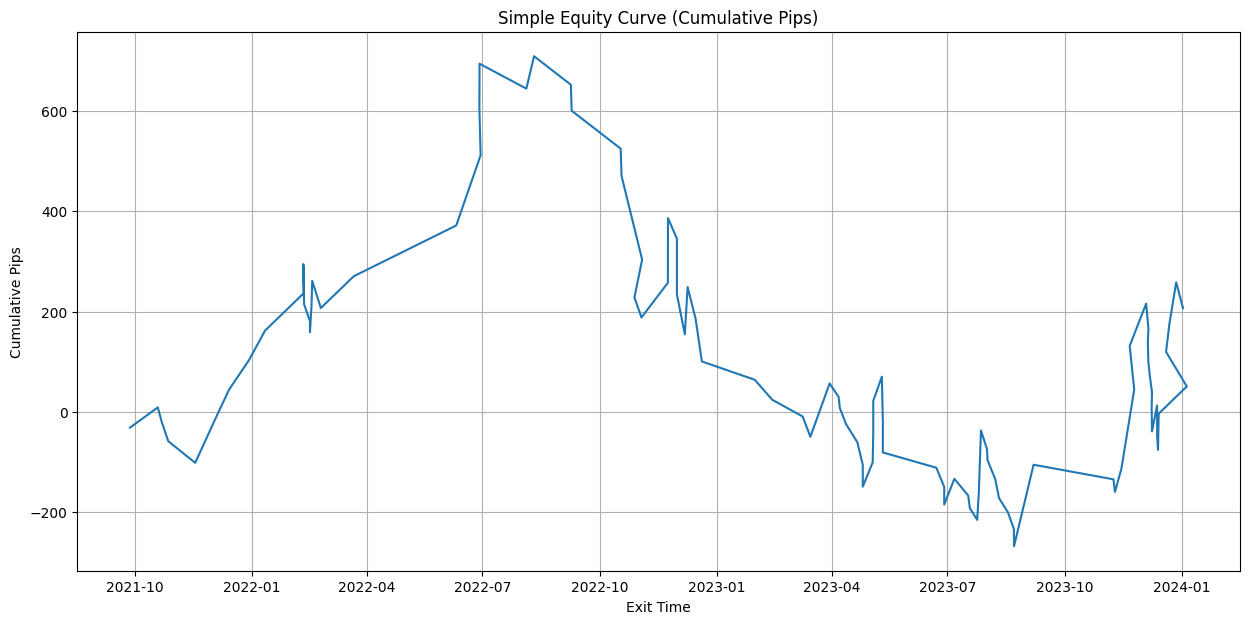


Sample of Trade Results (first 10):
                 entry_time signal_type  entry_price  sl_price  tp_price  \
0 2021-09-27 02:00:00+00:00   SELL_RULE      1.36666  1.369831  1.360318   
1 2021-10-18 22:00:00+00:00    BUY_RULE      1.37298  1.370958  1.377023   
2 2021-10-22 01:00:00+00:00    BUY_RULE      1.38013  1.377140  1.386110   
3 2021-10-25 13:00:00+00:00    BUY_RULE      1.37585  1.372083  1.383384   
4 2021-11-17 09:00:00+00:00   SELL_RULE      1.34313  1.347438  1.334514   
5 2021-12-01 16:00:00+00:00   SELL_RULE      1.33080  1.335271  1.321858   
6 2021-12-13 02:00:00+00:00   SELL_RULE      1.32489  1.327727  1.319216   
7 2021-12-29 02:00:00+00:00    BUY_RULE      1.34354  1.340621  1.349378   
8 2022-01-07 09:00:00+00:00    BUY_RULE      1.35545  1.352486  1.361377   
9 2022-02-08 08:00:00+00:00    BUY_RULE      1.35408  1.350355  1.361530   

  outcome                 exit_time  exit_price   pnl_pips  \
0  SL_HIT 2021-09-27 08:00:00+00:00    1.369831 -31.711050   
1 

In [37]:
# Cell 15: Basic Backtesting Loop for Rules-Based Signals

print("--- Starting Basic Backtest for Rules-Based Signals ---")

# Input DataFrames needed:
# 1. df_final_trades: Output from Cell 13 (H1 data with 'rules_signal', 'entry_price', 'stop_loss_price', 'take_profit_price')
#    This should only contain rows where a "BUY_RULE" or "SELL_RULE" was generated AND SL/TP were calculated.
# 2. df_h1_full_data: Your complete H1 OHLC DataFrame (e.g., df_h1_indicators, as it has OHLC)
#    It must have 'high' and 'low' columns for checking SL/TP.

if 'df_final_trades' in locals() and df_final_trades is not None and \
   'df_h1_indicators' in locals() and df_h1_indicators is not None:

    # Filter df_final_trades for actual trade signals with valid SL/TP
    actionable_signals = df_final_trades[
        (df_final_trades['rules_signal'] != "NO_RULE_SIGNAL") &
        (df_final_trades['stop_loss_price'].notna()) &
        (df_final_trades['take_profit_price'].notna())
    ].copy()

    if actionable_signals.empty:
        print("No actionable signals with SL/TP found to backtest.")
    else:
        print(f"Found {len(actionable_signals)} actionable rule-based signals to backtest.")
        
        trade_results = [] # To store details of each simulated trade
        
        # Ensure H1 data is sorted by time
        df_h1_full_data_sorted = df_h1_indicators.sort_index()

        for signal_idx, signal_row in actionable_signals.iterrows():
            entry_time = signal_idx # Timestamp of the H1 signal bar
            signal_type = signal_row['rules_signal']
            entry_price = signal_row['entry_price'] # Assumed entry at close of signal bar
            sl_price = signal_row['stop_loss_price']
            tp_price = signal_row['take_profit_price']
            
            # Get the H1 data from the bar *after* the signal bar onwards
            # The signal bar's close is entry; SL/TP checked from next bar
            h1_data_after_signal = df_h1_full_data_sorted.loc[df_h1_full_data_sorted.index > entry_time]
            
            exit_time = None
            exit_price = np.nan
            outcome = "UNKNOWN" # "TP_HIT", "SL_HIT", "NO_EXIT_IN_DATA"

            for bar_idx, bar_row in h1_data_after_signal.iterrows():
                current_bar_high = bar_row['high']
                current_bar_low = bar_row['low']
                # current_bar_open = bar_row['open'] # For more precise exit simulation if needed

                if signal_type == "BUY_RULE":
                    # Check SL first (more conservative if both hit in same bar)
                    if current_bar_low <= sl_price:
                        outcome = "SL_HIT"
                        exit_price = sl_price # Assume SL filled at SL price
                        exit_time = bar_idx
                        break 
                    # Then check TP
                    elif current_bar_high >= tp_price:
                        outcome = "TP_HIT"
                        exit_price = tp_price # Assume TP filled at TP price
                        exit_time = bar_idx
                        break
                elif signal_type == "SELL_RULE":
                    # Check SL first
                    if current_bar_high >= sl_price:
                        outcome = "SL_HIT"
                        exit_price = sl_price
                        exit_time = bar_idx
                        break
                    # Then check TP
                    elif current_bar_low <= tp_price:
                        outcome = "TP_HIT"
                        exit_price = tp_price
                        exit_time = bar_idx
                        break
            
            if outcome == "UNKNOWN" and not h1_data_after_signal.empty:
                outcome = "NO_EXIT_IN_DATA" # Reached end of data without SL/TP hit
                exit_time = h1_data_after_signal.index[-1]
                exit_price = h1_data_after_signal['close'].iloc[-1] # Exit at last known close

            # Calculate P&L
            pnl = np.nan
            if pd.notna(exit_price):
                if signal_type == "BUY_RULE":
                    pnl = exit_price - entry_price
                elif signal_type == "SELL_RULE":
                    pnl = entry_price - exit_price
            
            trade_results.append({
                "entry_time": entry_time,
                "signal_type": signal_type,
                "entry_price": entry_price,
                "sl_price": sl_price,
                "tp_price": tp_price,
                "outcome": outcome,
                "exit_time": exit_time,
                "exit_price": exit_price,
                "pnl_pips": pnl / pip_value_gbpusd if pd.notna(pnl) else np.nan # Assuming pip_value_gbpusd from Cell 13
            })

        # --- Analyze Results ---
        if trade_results:
            results_df = pd.DataFrame(trade_results)
            print("\n--- Backtest Results ---")
            print(f"Total Trades Simulated: {len(results_df)}")
            
            wins = results_df[results_df['outcome'] == "TP_HIT"]
            losses = results_df[results_df['outcome'] == "SL_HIT"]
            no_exit = results_df[results_df['outcome'] == "NO_EXIT_IN_DATA"]

            print(f"Wins (TP Hit): {len(wins)}")
            print(f"Losses (SL Hit): {len(losses)}")
            print(f"No Exit (End of Data): {len(no_exit)}")

            if len(wins) + len(losses) > 0:
                win_rate = len(wins) / (len(wins) + len(losses)) * 100
                print(f"Win Rate (TP_HIT / (TP_HIT + SL_HIT)): {win_rate:.2f}%")
            else:
                print("Win Rate: N/A (no completed trades)")

            if pd.notna(results_df['pnl_pips'].sum()):
                total_pnl_pips = results_df['pnl_pips'].sum()
                print(f"Total P&L (pips): {total_pnl_pips:.2f}")
                
                avg_win_pips = results_df[results_df['pnl_pips'] > 0]['pnl_pips'].mean() if len(wins) > 0 else 0
                avg_loss_pips = results_df[results_df['pnl_pips'] < 0]['pnl_pips'].mean() if len(losses) > 0 else 0
                print(f"Average Win (pips): {avg_win_pips:.2f}")
                print(f"Average Loss (pips): {avg_loss_pips:.2f}") # Will be negative
                
                if avg_loss_pips != 0:
                    risk_reward_ratio = abs(avg_win_pips / avg_loss_pips)
                    print(f"Average Risk:Reward Ratio (AvgWin / Abs(AvgLoss)): {risk_reward_ratio:.2f}")
                
                # Simple Equity Curve (cumulative P&L in pips)
                results_df['cumulative_pnl_pips'] = results_df['pnl_pips'].cumsum()
                plt.figure(figsize=(15,7))
                plt.plot(results_df['exit_time'], results_df['cumulative_pnl_pips']) # Use exit_time for x-axis
                plt.title('Simple Equity Curve (Cumulative Pips)')
                plt.xlabel('Exit Time')
                plt.ylabel('Cumulative Pips')
                plt.grid(True)
                plt.show()
            else:
                print("Could not calculate P&L statistics.")
            
            print("\nSample of Trade Results (first 10):")
            print(results_df.head(10))
        else:
            print("No trades were processed by the backtester.")
else:
    print("Error: `df_final_trades` (with SL/TP) or `df_h1_indicators` (full H1 data) not found.")
    print("Please ensure Cell 13 and your H1 data loading cell ran successfully.")

print("--- Basic Backtest Complete ---")

In [38]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt # Import for plotting
import seaborn as sns         # Import for enhanced visualizations

# --- Provided Function by Sakhe ---
# Function to calculate 50 SMA
def calculate_sma(dataframe, price_column='close', period=50, sma_column_name=None):
    """Calculates the Simple Moving Average (SMA) for a given DataFrame."""
    if not isinstance(dataframe, pd.DataFrame) or price_column not in dataframe.columns:
        print(f"Error: Invalid DataFrame or price column '{price_column}' not found.")
        return None

    if sma_column_name is None:
        sma_column_name = f'SMA_{period}'

    try:
        df_copy = dataframe.copy()
        df_copy[sma_column_name] = df_copy[price_column].rolling(window=period).mean()
        return df_copy
    except Exception as e:
        print(f"Error calculating SMA: {e}")
        return None

# --- Helper Function for Consecutive Candles ---
def count_consecutive_candles(series):
    """Counts consecutive positive (bullish) or negative (bearish) values."""
    consecutive_count = [0] * len(series)
    for i in range(1, len(series)):
        if np.sign(series.iloc[i]) == np.sign(series.iloc[i-1]):
            consecutive_count[i] = consecutive_count[i-1] + np.sign(series.iloc[i])
        else:
            consecutive_count[i] = np.sign(series.iloc[i])
    return consecutive_count

# --- Main Script ---

# 1. Load Data
try:
    df = pd.read_csv('GBPUSDm_D1_train.csv', index_col='time', parse_dates=True)
except FileNotFoundError:
    print("File not found. Using dummy data for demonstration.")
    dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
    price_data = np.random.randn(200, 4).cumsum(axis=0) + 1.5
    df = pd.DataFrame(price_data, columns=['open', 'high', 'low', 'close'], index=dates)
    df.index.name = 'time'

# --- 2. Feature Engineering ---

# Define parameters for calculations
ATR_PERIOD = 14
SMA_PERIOD = 50
SLOPE_PERIOD_M = 5
BODY_SIZE_PERIOD_N = 14

# a) Calculate D1 50 SMA using your function
df = calculate_sma(df, period=SMA_PERIOD)
sma_col_name = f'SMA_{SMA_PERIOD}'

# b) Volatility Feature: Normalized ATR
# Calculate ATR using pandas_ta
df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=ATR_PERIOD)
# Normalize ATR by the closing price
df['normalized_atr'] = (df['atr'] / df['close']) * 100

# c) Trend Strength/Direction Feature: Slope of D1 50 SMA
# Calculate the change in SMA value over the last M bars
df['sma_slope'] = df[sma_col_name].diff(periods=SLOPE_PERIOD_M)

# d) Price Action Feature: Normalized Average Candle Body Size
# Calculate candle body size and range
df['body_size'] = abs(df['close'] - df['open'])
df['range'] = df['high'] - df['low']

# Calculate rolling averages of body and range
avg_body_size = df['body_size'].rolling(window=BODY_SIZE_PERIOD_N).mean()
avg_range = df['range'].rolling(window=BODY_SIZE_PERIOD_N).mean()

# Calculate the normalized body size. Avoid division by zero.
df['normalized_body_size'] = (avg_body_size / avg_range).replace([np.inf, -np.inf], 0)

# e) Price Action Feature: Consecutive Bullish/Bearish Candles
# First, determine if a candle is bullish (1) or bearish (-1)
df['candle_direction'] = np.sign(df['close'] - df['open'])
# Now, count the consecutive candles
df['consecutive_candles'] = count_consecutive_candles(df['candle_direction'])

# --- 3. Final DataFrame Creation ---

# Define the list of engineered feature columns we want to keep for the model
feature_columns = [
    'normalized_atr',
    'sma_slope',
    'normalized_body_size',
    'consecutive_candles'
]

# Create the new DataFrame with only our features
features_df = df[feature_columns].copy()

# IMPORTANT: Remove initial rows with NaNs due to indicator calculations
initial_rows = features_df.shape[0]
features_df.dropna(inplace=True)
final_rows = features_df.shape[0]

print(f"Removed {initial_rows - final_rows} rows with NaN values.")
print("\n--- Final Features DataFrame ---")
print(features_df.head())
print("\n--- Statistical Summary of Features ---")
print(features_df.describe())


# --- PLOTTING SECTION ---
print("\n--- Generating Plots for Features ---")

# Plotting each feature
plt.figure(figsize=(15, 10))

# Plot 1: Normalized ATR
plt.subplot(4, 1, 1) # (rows, columns, plot_number)
features_df['normalized_atr'].plot(title='Normalized ATR', grid=True)
plt.ylabel('ATR (%)')

# Plot 2: SMA Slope
plt.subplot(4, 1, 2)
features_df['sma_slope'].plot(title=f'SMA Slope ({SLOPE_PERIOD_M}-period change)', grid=True)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a horizontal line at 0 for reference
plt.ylabel('Slope')

# Plot 3: Normalized Average Candle Body Size
plt.subplot(4, 1, 3)
features_df['normalized_body_size'].plot(title=f'Normalized Average Candle Body Size ({BODY_SIZE_PERIOD_N}-period)', grid=True)
plt.ylabel('Normalized Size')

# Plot 4: Consecutive Bullish/Bearish Candles
plt.subplot(4, 1, 4)
features_df['consecutive_candles'].plot(title='Consecutive Bullish/Bearish Candles', grid=True)
plt.ylabel('Count')
plt.xlabel('Time')


plt.tight_layout() # Adjusts subplot parameters for a tight layout
plt.show() # Display all plots

# You can also plot specific relationships, e.g., price and SMA
plt.figure(figsize=(15, 6))
df['close'].plot(label='Close Price', color='blue')
df[sma_col_name].plot(label=f'SMA {SMA_PERIOD}', color='orange', linestyle='--')
plt.title('Close Price and Simple Moving Average')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Example: Distribution of sma_slope using a histogram
plt.figure(figsize=(8, 5))
sns.histplot(features_df['sma_slope'].dropna(), kde=True, bins=50)
plt.title('Distribution of SMA Slope')
plt.xlabel('SMA Slope')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Example: Distribution of normalized_atr
plt.figure(figsize=(8, 5))
sns.histplot(features_df['normalized_atr'].dropna(), kde=True, bins=50)
plt.title('Distribution of Normalized ATR')
plt.xlabel('Normalized ATR (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

ImportError: cannot import name 'NaN' from 'numpy' (c:\Users\User\Documents\Computer Science\Year 2\Semester 2\SCS 2209\Mini Project\Model\forex_hybrid_robot\forex_bot_env\lib\site-packages\numpy\__init__.py)